In [1]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
from array import array
import collections

inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
outputdir = inputdir+'xsec_theta_weightedV4/' 
output_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_filesV4/'
input_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
lib_function_dir = '/home/tmettler/Desktop/uBoone/do_plots/'

plot_systematic = 0

# helper functions
globale = imp.load_source('globale',lib_function_dir+'globale.py')
NuCC = imp.load_source('NuCC_function',lib_function_dir+'NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function',lib_function_dir+'NuCCWeight_function.py')

Welcome to JupyROOT 6.10/08


In [2]:
#!jupyter nbconvert --to script numuCCana_muon_cut_weight.ipynb

In [3]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# CRTinBNB tagger, Overlay or MC

In [4]:
# Load input files
#inputdir = '/home/thomasm/numuCC/V33/10kevents/'
outputdir_png, outputdir_root, outputdir_pdf = NuCC.prepareOutput2(outputdir)
try:
    os.stat(output_filedir)
except:
    os.mkdir(output_filedir)
RootFile = ROOT.TFile(output_filedir+"xsec_theta_wighted.root","RECREATE");

#filename_overlay = 'NuCCana_overlay_V26_weight.root'
#filename_overlay = 'NuCCana_overlay_v25_weighted_all.root'
filename_overlay = 'NuCCana_overlay_V26_mar18.root'

filename_data = 'NuCCana_data_V25.root'
filename_ext = 'NuCCana_ext_V25.root'
filename_dirt = 'NuCCana_dirt_V26_weight.root'
    
tree_name = 'numuCCAna'

In [5]:
#Open all the trees of the four files (data, ext, dirt, overlay)

data, ext, dirt, overlay = NuCC.openTrees(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
NuCC.printNumberOfEntries(data,ext,dirt,overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
pot_dirt =  NuCC.getPOT(inputdir,filename_dirt,tree_name)
#V25 files
pot_data =    7.644e+18  # best with tor875
data_trigger = 1838700.0 #2220362.0 #1854495.0 #4743794 # 1987072.0 # E1DCNT_wcut
ext_trigger =  18997529.0  #2120135 #5685315 # EXT

print 'POT: '
print 'Data:\t\t', pot_data
print 'Ext:\t\t', 0
print 'Overlay:\t', pot_overlay
print 'Dirt:\t\t', pot_dirt
print ''
sample = [data,ext,overlay,dirt]
scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}

scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)

scale[dirt] = scale[dirt]
scale[overlay] = scale[overlay]
print 'Scalefactors: '
print 'Data:\t\t', scale[data]
print 'Ext:\t\t', scale[ext]
print 'Overlay:\t', scale[overlay]
print 'Dirt:\t\t', scale[dirt]


Overlay: Number of Entries:	1012051
Data: Number of Entries:	28005
Ext: Number of Entries:		222702
Dirt: Number of Entries:	40808

POT: 
Data:		7.644e+18
Ext:		0
Overlay:	1.26811760704e+21
Dirt:		1.25019694173e+20

Scalefactors: 
Data:		1.0
Ext:		0.0967862715198
Overlay:	0.0060278320856
Dirt:		0.0611423668132


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [6]:
if 1:
    filename_overlay = filename_overlay+'out4_noflux.root'
    #filename_overlay = 'NuCCana_overlay_points_1kev.rootout2.root'
    filename_data = filename_data+'out4.root'
    filename_ext = filename_ext+'out4.root'
    filename_dirt = filename_dirt+'out4.root'

    tree_name = 't_out'

    data_out, ext_out, dirt_out, overlay_out = NuCC.openTreesOut(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
    NuCC.printNumberOfEntries(data_out,ext_out,dirt_out,overlay_out)

    sample_out = [data_out,ext_out,overlay_out,dirt_out]
    scale_out = {data_out:1.0,ext_out:1.0,overlay_out:1.0,dirt_out:1.0}
    name_out = {data_out:'data',ext_out:'ext',overlay_out:'overlay',dirt_out:'dirt'}

    scale_out[data_out], scale_out[ext_out], scale_out[dirt_out], scale_out[overlay_out] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)
    scale_out[dirt_out] = scale_out[dirt_out]
    scale_out[overlay_out] = scale_out[overlay_out]

Overlay: Number of Entries:	1013969
Data: Number of Entries:	28004
Ext: Number of Entries:		222701
Dirt: Number of Entries:	40800



In [7]:
##### flux and number of tragets parameters###
flux = 1.16859e11/1.592e20 # flux per POT per cm2
print flux
flux = 7.3789785277e-10
print flux
roh_data = 1.3836 #data denisity g/cm3
roh_MC = 1.3954 # MC denisity g/cm3
mol = 39.95 # g for argon
N_A = 6.022140857e23 # molec/mol avogadro zahl
N_nucleons = 40.0
V_fid = ((254.8-10)-(-1.55+10))*((117.47-10)-(-115.53+10))*((1036.9-50)-(-0.1+10))
print 'Fiducial Volume: ', V_fid
##############################################

beam_flux = flux * pot_data
print 'Beam flux = {:.5e}'.format(beam_flux),' /cm2'
N_tot = roh_data*N_A*N_nucleons*V_fid/mol
print 'Number of target nuclei= {:.5e}'.format(N_tot),' /cm3'

7.34038944724e-10
7.3789785277e-10
Fiducial Volume:  49184671.35
Beam flux = 5.64049e+09  /cm2
Number of target nuclei= 4.10331e+31  /cm3


In [8]:
# Define signals

fidVol = '(Nu_Vx_sce>(-1.55+10) && Nu_Vx_sce<(254.8-10)) && (Nu_Vy_sce>(-115.53+10) && Nu_Vy_sce<(117.47-10)) &&(Nu_Vz_sce>(-0.1+10) && Nu_Vz_sce<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5' # numu CC signal definition
numu_true = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG!=13 && MCTrackPurity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    
num_fidVol = {}
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
overlay_signals = {'numu_signal','numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other'}

In [9]:
for x in sample_out:
    x.SetAlias('muon','(track_key == key_muon)')

num_fidVol = {}
for x in sample_out:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)

In [10]:
# Load the global variables for access of functions
NuCC.loadGlobal(data,ext,dirt,overlay,data_out,ext_out,dirt_out,overlay_out,scale,scale_out,tot_num_fidVol,overlay_signals,sample,sample_out, name,name_out, outputdir_png, outputdir_root,outputdir_pdf)
#NuCC.printGlobal()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [11]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

In [12]:
'''
track_start_border_x = '(TrackStart_x_sce <(-1.55+1) || TrackStart_x_sce > (254.8-1))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+1) || TrackEnd_x_sce > (254.8-1))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+1) || TrackStart_y_sce > (117.47-1))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+1) || TrackEnd_y_sce > (117.47-1))'
track_start_border_z = '(TrackStart_z_sce <(0.1+1) || TrackStart_z_sce > (1036.9-1))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+1) || TrackEnd_z_sce > (1039.9-1))'
'''
track_start_border_x = '(TrackStart_x_sce <(-1.55+5) || TrackStart_x_sce > (254.8-5))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+5) || TrackEnd_x_sce > (254.8-5))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+5) || TrackStart_y_sce > (117.47-5))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+5) || TrackEnd_y_sce > (117.47-5))'
track_start_border_z = '(TrackStart_z_sce <(0.1+5) || TrackStart_z_sce > (1036.9-5))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+5) || TrackEnd_z_sce > (1039.9-5))'

track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'


data.SetAlias("track_end_uncontained",track_end_uncontained)
ext.SetAlias("track_end_uncontained",track_end_uncontained)
overlay.SetAlias("track_end_uncontained",track_end_uncontained)
dirt.SetAlias("track_end_uncontained",track_end_uncontained)
data_out.SetAlias("track_end_uncontained",track_end_uncontained)
ext_out.SetAlias("track_end_uncontained",track_end_uncontained)
overlay_out.SetAlias("track_end_uncontained",track_end_uncontained)
dirt_out.SetAlias("track_end_uncontained",track_end_uncontained)

data.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-4)<0.9 || crtt0_time==-1)")
ext.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195-4)<0.9 || crtt0_time==-1)")
overlay.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
dirt.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
data_out.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.95)<0.9 || crtt0_time==-1)")
ext_out.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195-3.95)<0.9 || crtt0_time==-1)")
overlay_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
dirt_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")

crt_tom_cut = 'nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'

data.SetAlias("crt_tom_cut",crt_tom_cut)
ext.SetAlias("crt_tom_cut",crt_tom_cut)
overlay.SetAlias("crt_tom_cut",crt_tom_cut)
dirt.SetAlias("crt_tom_cut",crt_tom_cut)
data_out.SetAlias("crt_tom_cut",crt_tom_cut)
ext_out.SetAlias("crt_tom_cut",crt_tom_cut)
overlay_out.SetAlias("crt_tom_cut",crt_tom_cut)
dirt_out.SetAlias("crt_tom_cut",crt_tom_cut)

weight_name = 'EventWeight*TunedCentralValue_Genie'


In [13]:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
name = '_rate_binned'
side_right = 'right'
side_left = 'left'
start = time.time()
#NuCC_w.make_stacked_histo_weightV2(cut,'cos(TrackTheta)','EventWeight','cos(Theta)',-10,270,40,'CosTheta'+name,side_left)
end = time.time()
print(end - start)

2.59876251221e-05


In [14]:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
name = '_rate_binned_mcc8'
side_right = 'right'
side_left = 'left'
start = time.time()
#NuCC_w.make_stacked_histo_weight_MCC8(cut,'cos(TrackTheta)','EventWeight','cos(Theta)',-10,270,40,'CosTheta'+name,side_left)
end = time.time()
print(end - start)

3.50475311279e-05


In [15]:
cut = 'fidVol && muon'
#eff , pur = NuCC_w.printEff_w(cut)

In [16]:
# calculate total flux integrated cross section:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
N_data = data_out.GetEntries(cut)
N_ext  = ext_out.GetEntries(cut)*scale_out[ext_out]
N_dirt = dirt_out.GetEntries(cut)*scale_out[dirt_out]
N_overlay = overlay_out.GetEntries(cut+'&& !numu_signal')*scale_out[overlay_out]
N_signal = overlay_out.GetEntries(cut+'&& numu_signal')*scale_out[overlay_out]
N_true = overlay_out.GetEntries('numu_true')*scale_out[overlay_out]

h_weight_func = ROOT.TH1F("h_weight_func",'h_weight_func',10000,0,1000)
globale.overlay_out.Draw(weight_name+'>>h_weight_func',cut+' && 1','0')
dirt_pass_weight = h_weight_func.GetMean() 
globale.overlay_out.Draw(weight_name+'>>h_weight_func',cut+' && numu_signal','0') # weights for signal definition
overlay_signal = h_weight_func.GetMean()
globale.overlay_out.Draw(weight_name+'>>h_weight_func',cut+' && !numu_signal','0') # weights for signal definition
overlay_pass_weight = h_weight_func.GetMean()

overlay_out.Draw(weight_name+'>>h_weight_func',numu_true,'0') # weights for signal definition
overlay_true_weight = h_weight_func.GetMean()

N_dirt = N_dirt*dirt_pass_weight
N_overlay = N_overlay*overlay_pass_weight
N_signal = N_signal*overlay_signal
N_true = N_true*overlay_true_weight
eff = N_signal/N_true

sigma_tot = (N_data- (N_ext+N_dirt+N_overlay))/(eff*beam_flux*N_tot)
print 'Number of data:', N_data
print 'Number of ext:', N_ext
print 'Number of dirt:', N_dirt
print 'Number of overlay:', N_overlay
print 'Number of overlay signal:', N_signal
print 'Efficiency: ',eff
print 'Total integrated cross section:', sigma_tot

sigma_tot_MC = (N_signal)/(eff*beam_flux*N_tot)
print 'Total integrated cross section for MC:', sigma_tot_MC

Number of data: 1348
Number of ext: 142.179032863
Number of dirt: 32.1859727109
Number of overlay: 199.17724577
Number of overlay signal: 973.277128269
Efficiency:  0.525781702998
Total integrated cross section: 8.00767014933e-39
Total integrated cross section for MC: 7.99796832424e-39


In [17]:


#mom_bins = [ 0.00, 0.18, 0.30, 0.45, 0.77, 1.28, 2.50 ]
#binnum = len(mom_bins) - 1
#h_xsec_mom = ROOT.TH1F('h_xsec_mom','h_xsec_mom',binnum,array('f',mom_bins))

mom_bins = [ -1.00, -0.50, 0.00, 0.28, 0.47, 0.63, 0.765, 0.865, 0.935, 1.00 ]
#mom_bins = [ -1.00, 0.00, 1.00 ]

binnum = len(mom_bins) - 1
h_xsec_mom = ROOT.TH1F('h_xsec_mom','h_xsec_mom',binnum,array('f',mom_bins))


In [18]:
def draw_adding():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/25.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()

    pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/25.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();
    
    return prelim, pot_latex

def draw_sim():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/20.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    
    return prelim

856

Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Histograms are filled with weights
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/png/h_eff_trueTheta.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/root/h_eff_trueTheta.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/pdf/h_eff_trueTheta.pdf has been created


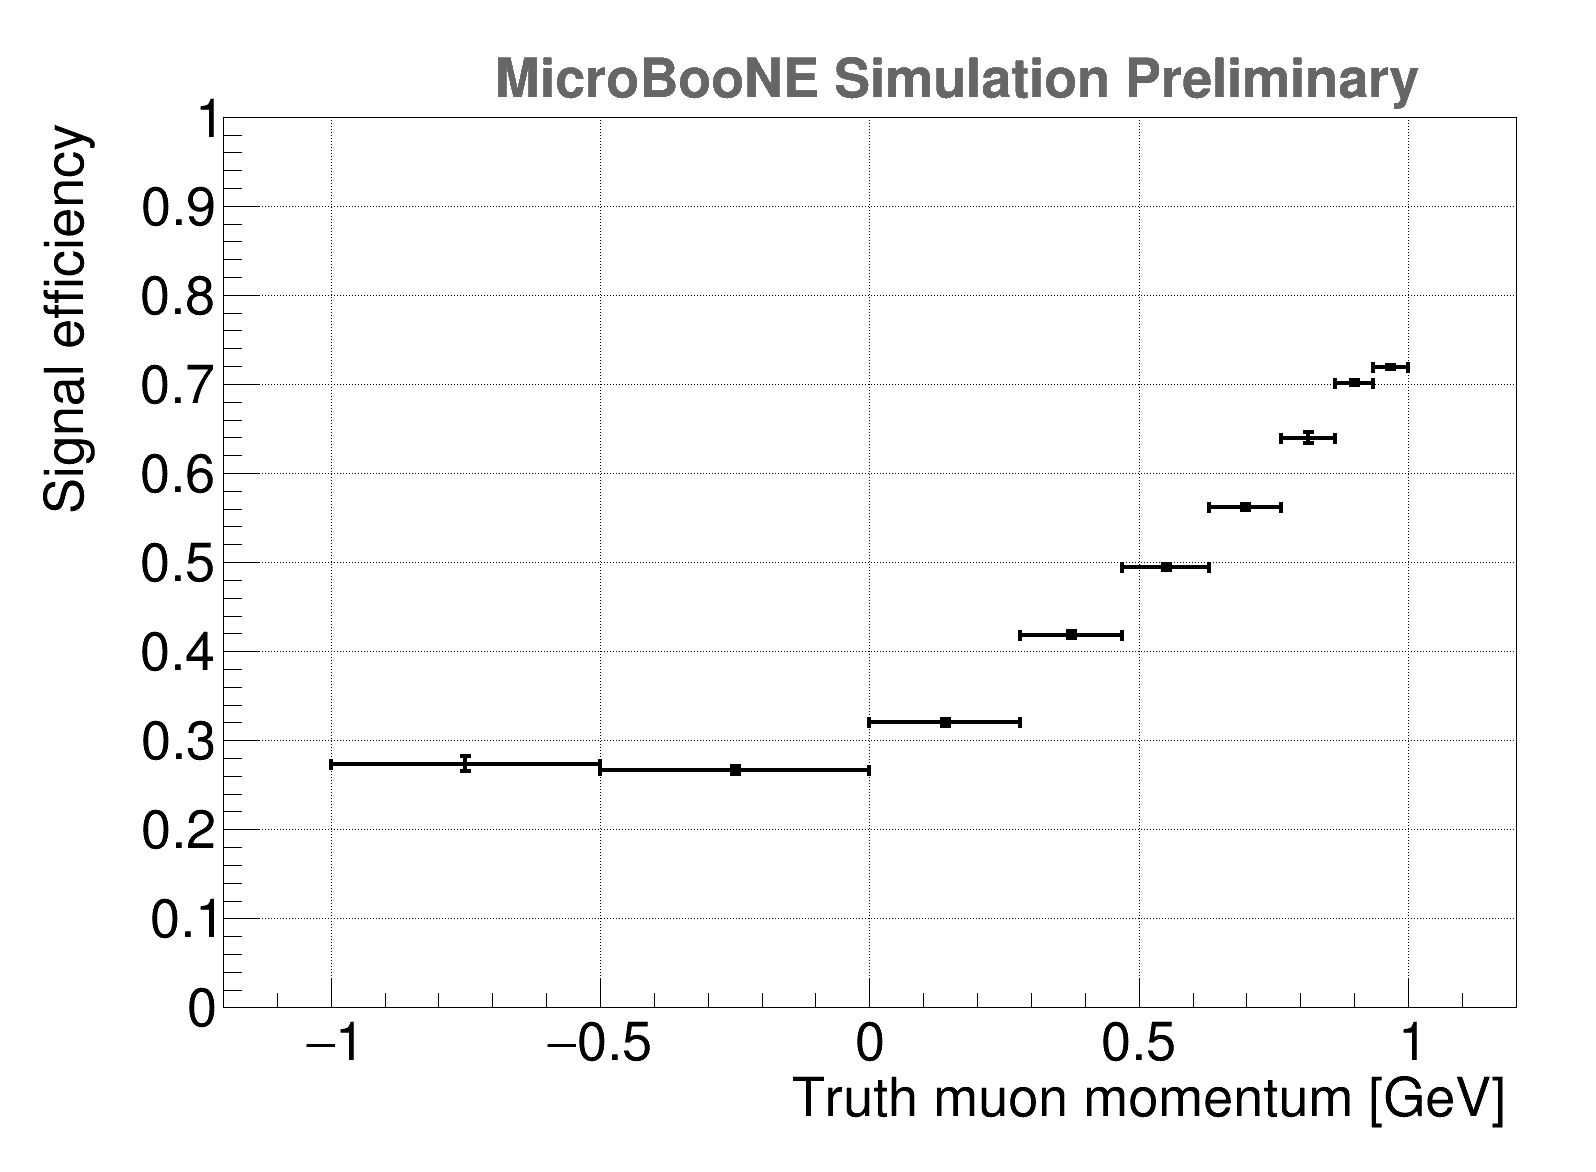

In [19]:
xstart = 0
xend = 2
xbin = 100
weight_name = 'EventWeight*TunedCentralValue_Genie'
title = 'true moum theta efficiency'
nenner_cut = 'numu_true'
zahler_cut = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && numu_signal'
h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,binnum,array('f',mom_bins))
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,binnum,array('f',mom_bins))
#h_init_eff_energy = fill_histo(globale.overlay_out,'MCNu_Energy',h_init_eff_energy,zahler_cut)
#h_init_eff_energy_1 = fill_histo(globale.overlay_out,'MCNu_Energy',h_init_eff_energy_1,nenner_cut)
globale.overlay_out.Draw('cos(MCNu_leptonTheta)>>h_init_eff_energy',weight_name+'*('+zahler_cut+')')
globale.overlay_out.Draw('cos(MCNu_leptonTheta)>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
eff =  ROOT.TEfficiency(h_init_eff_energy,h_init_eff_energy_1)
eff.SetStatisticOption(ROOT.TEfficiency.kFCP)#;  // to set option for errors (see ref doc)
eff.SetConfidenceLevel(0.68)
eff.SetTitle(title)
eff.Draw("AP")
ROOT.gPad.Update()
graph = eff.GetPaintedGraph()
graph.SetMinimum(0)
graph.SetMaximum(1)
graph.SetLineWidth(2)
graph.GetXaxis().SetTitle("Truth muon momentum [GeV]")
graph.GetYaxis().SetTitle("Signal efficiency")
graph.GetYaxis().SetTitleSize(0.05)
graph.GetYaxis().SetTitleOffset(0.0)
graph.GetYaxis().SetLabelSize(0.05)
graph.GetXaxis().SetTitleSize(0.05)
graph.GetXaxis().SetLabelSize(0.05)
graph.GetXaxis().SetTitleOffset(1)
graph.SetLineColor(ROOT.kBlack)
graph.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
graph.Draw("AP")
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_eff_trueTheta.png")
c1.SaveAs(globale.outputdir_root + "h_eff_trueTheta.root")
c1.SaveAs(globale.outputdir_pdf + "h_eff_trueTheta.pdf")

eff.Write("h_eff_true")

99928

Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/root/h2_true_costheta.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/png/h2_true_costheta.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/pdf/h2_true_costheta.pdf has been created


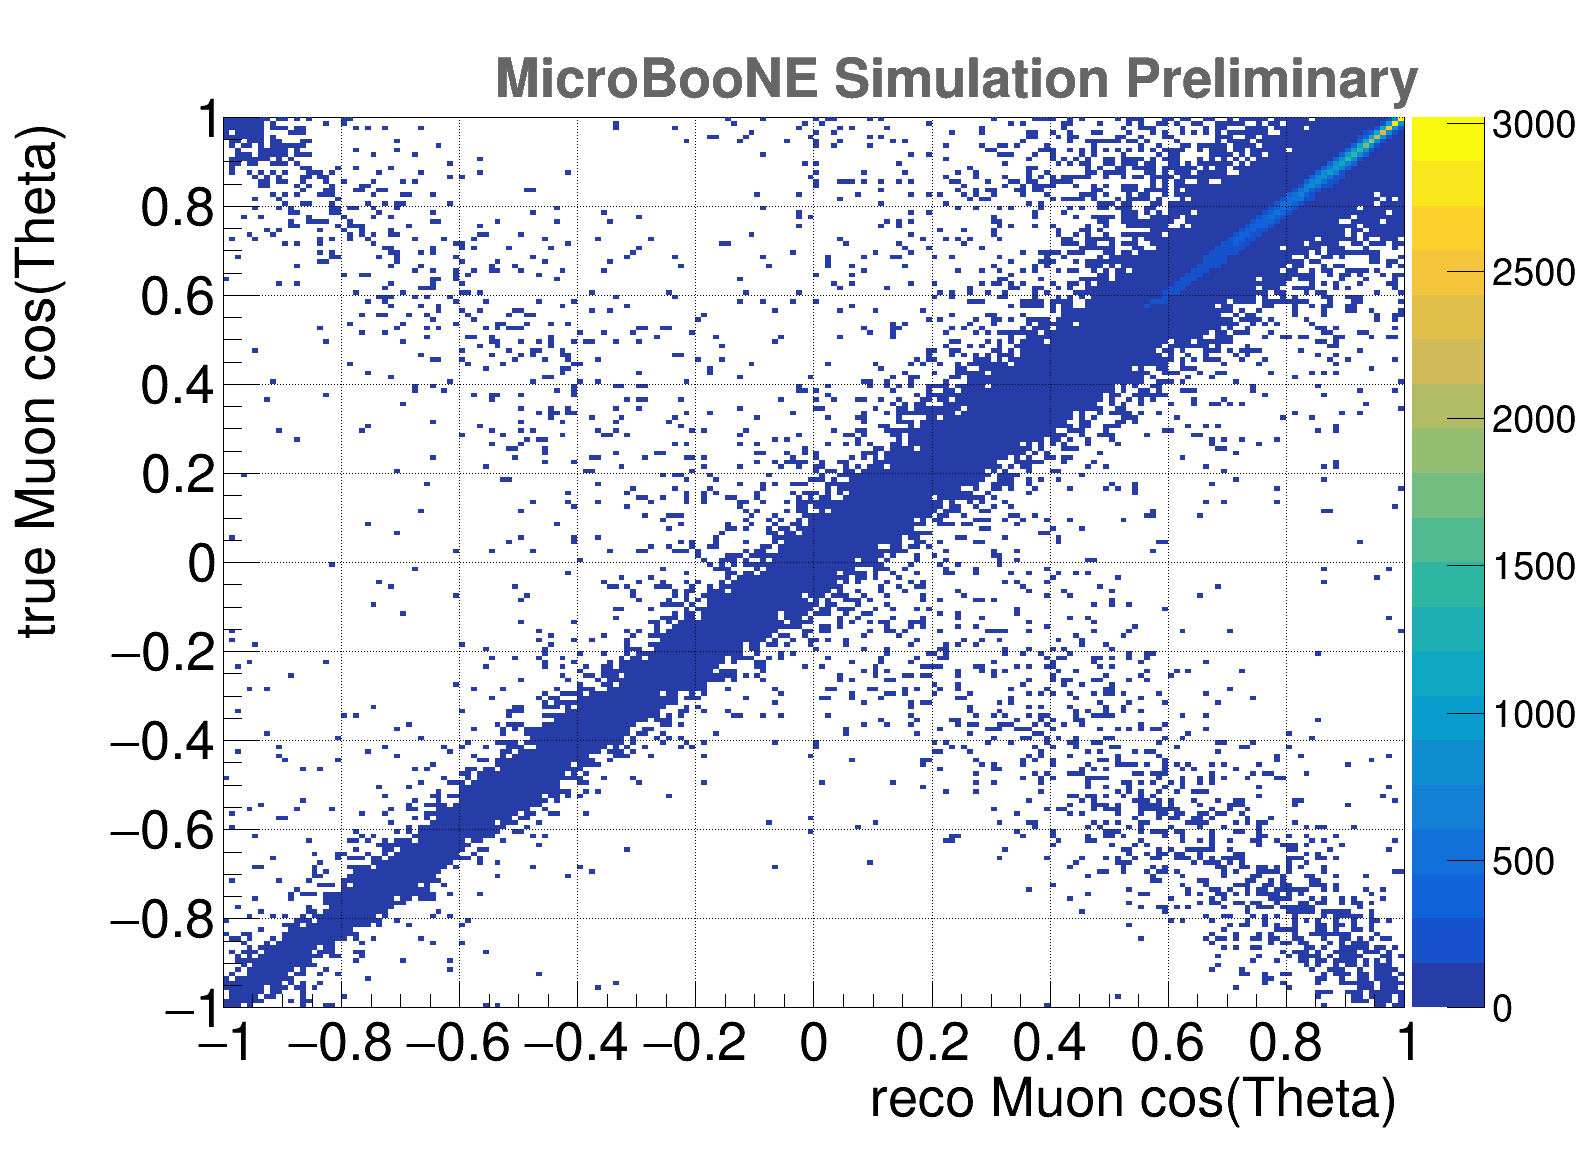

In [20]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',200,-1,1,200,-1,1)
globale.overlay_out.Draw('cos(MCNu_leptonTheta):cos(TrackTheta)'+'>>h_migration',weight_name+'*('+cut+'&& numu_signal)','')
h_migration.SetXTitle("reco Muon cos(Theta)")
h_migration.SetYTitle("true Muon cos(Theta)")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.12)
h_migration.Draw("colz")
prelim = draw_sim()
prelim.Draw()
#h_migration.Draw("same text")
c1.Draw()
c1.SaveAs(globale.outputdir_root + "h2_true_costheta.root")
c1.SaveAs(globale.outputdir_png + "h2_true_costheta.png")
c1.SaveAs(globale.outputdir_pdf + "h2_true_costheta.pdf")

h_migration.Write("h2_true_theta_fine")

1660

Warning in <TFile::Append>: Replacing existing TH1: h_migration (Potential memory leak).
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/root/h2_true_Theta_bin.root has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/png/h2_true_Theta_bin.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/pdf/h2_true_Theta_bin.pdf has been created


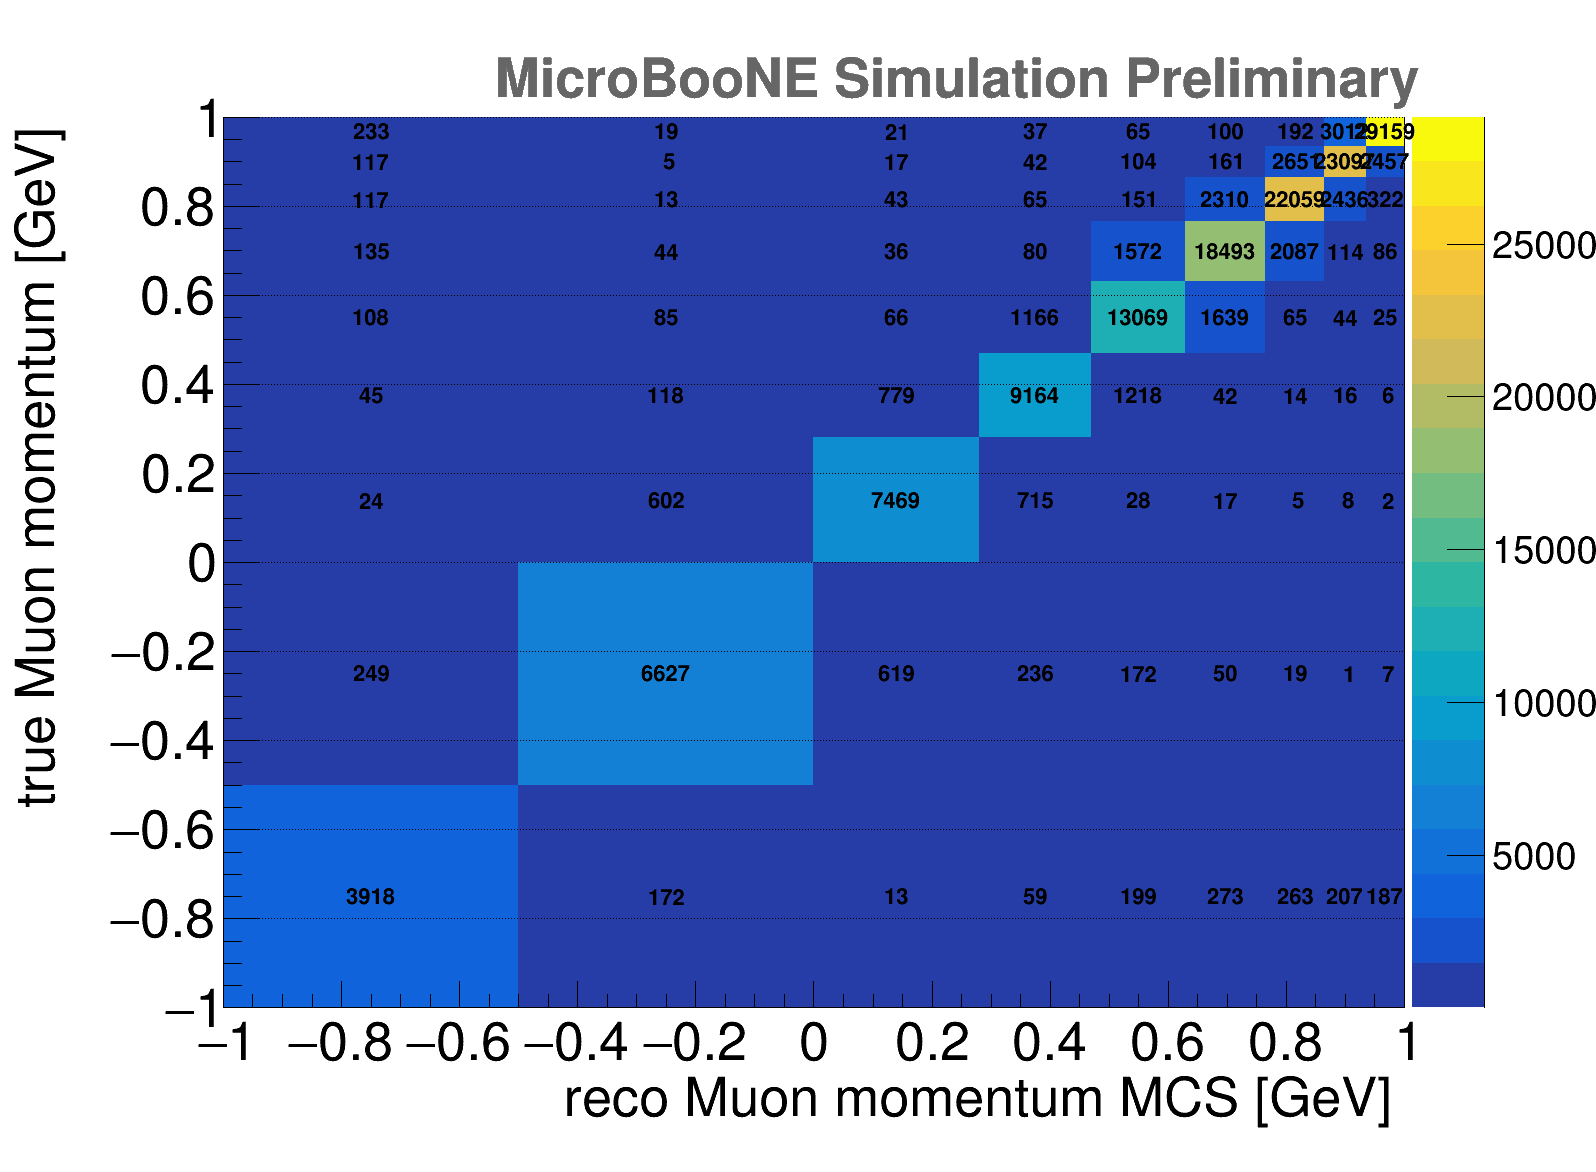

In [21]:
h_migration = ROOT.TH2F("h_migration",'Truth vs. Reco',binnum,array('f',mom_bins),binnum,array('f',mom_bins))
globale.overlay_out.Draw('cos(MCNu_leptonTheta):cos(TrackTheta)'+'>>h_migration',weight_name+'*('+cut+'&& numu_signal)','')
#globale.overlay_out.Draw('cos(MCNu_leptonTheta):cos(TrackTheta)'+'>>h_migration',weight_name+'*( numu_true)','')
h_migration.SetXTitle("reco Muon momentum MCS [GeV]")
h_migration.SetYTitle("true Muon momentum [GeV]")
h_migration.GetYaxis().SetTitleSize(0.05)
h_migration.GetYaxis().SetTitleOffset(0.0)
h_migration.GetYaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleSize(0.05)
h_migration.GetXaxis().SetLabelSize(0.05)
h_migration.GetXaxis().SetTitleOffset(1)
h_migration.SetLineColor(ROOT.kBlack)
h_migration.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.12)
ROOT.gStyle.SetPaintTextFormat("2.0f");
h_migration.Draw("colz")
h_migration.Draw("same text")
c1.SetGrid(0)
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_root + "h2_true_Theta_bin.root")
c1.SaveAs(globale.outputdir_png + "h2_true_Theta_bin.png")
c1.SaveAs(globale.outputdir_pdf + "h2_true_Theta_bin.pdf")

h_migration.Write("h2_true_theta_bin")

[[7.40215228e-01 3.12035371e-02 2.71908926e-03 3.92496553e-03
  6.63480804e-03 5.95581221e-03 4.26803676e-03 4.07304116e-03
  7.09840199e-03]
 [3.24447638e-02 8.30320238e-01 6.78773140e-02 1.03922957e-02
  5.24562933e-03 1.92477340e-03 4.80080818e-04 1.73078860e-04
  5.81175163e-04]
 [2.54350944e-03 7.75917143e-02 8.42091031e-01 6.82907020e-02
  4.08055537e-03 1.58586257e-03 1.57254451e-03 5.83800641e-04
  6.46496607e-04]
 [1.12417581e-02 2.95241778e-02 8.05705514e-02 8.03778359e-01
  7.16539993e-02 3.51849495e-03 2.35189262e-03 1.45986831e-03
  1.11999219e-03]
 [3.76793363e-02 2.16063344e-02 3.10931368e-03 1.06811854e-01
  8.03437131e-01 6.94098372e-02 5.49634477e-03 3.62118968e-03
  1.98602630e-03]
 [5.16769587e-02 6.30239185e-03 1.94246959e-03 3.64320166e-03
  1.00731752e-01 8.16610556e-01 8.39606115e-02 5.61136617e-03
  3.05039801e-03]
 [4.97208836e-02 2.40242575e-03 5.17172549e-04 1.22021309e-03
  3.99798812e-03 9.21452579e-02 8.01630776e-01 9.25358144e-02
  5.84147668e-03]
 [3.90

843

Warning in <TFile::Append>: Replacing existing TH1: h_migration (Potential memory leak).
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/png/h_mitigation_matrix_theta.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/root/h_mitigation_matrix_theta.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/pdf/h_mitigation_matrix_theta.pdf has been created


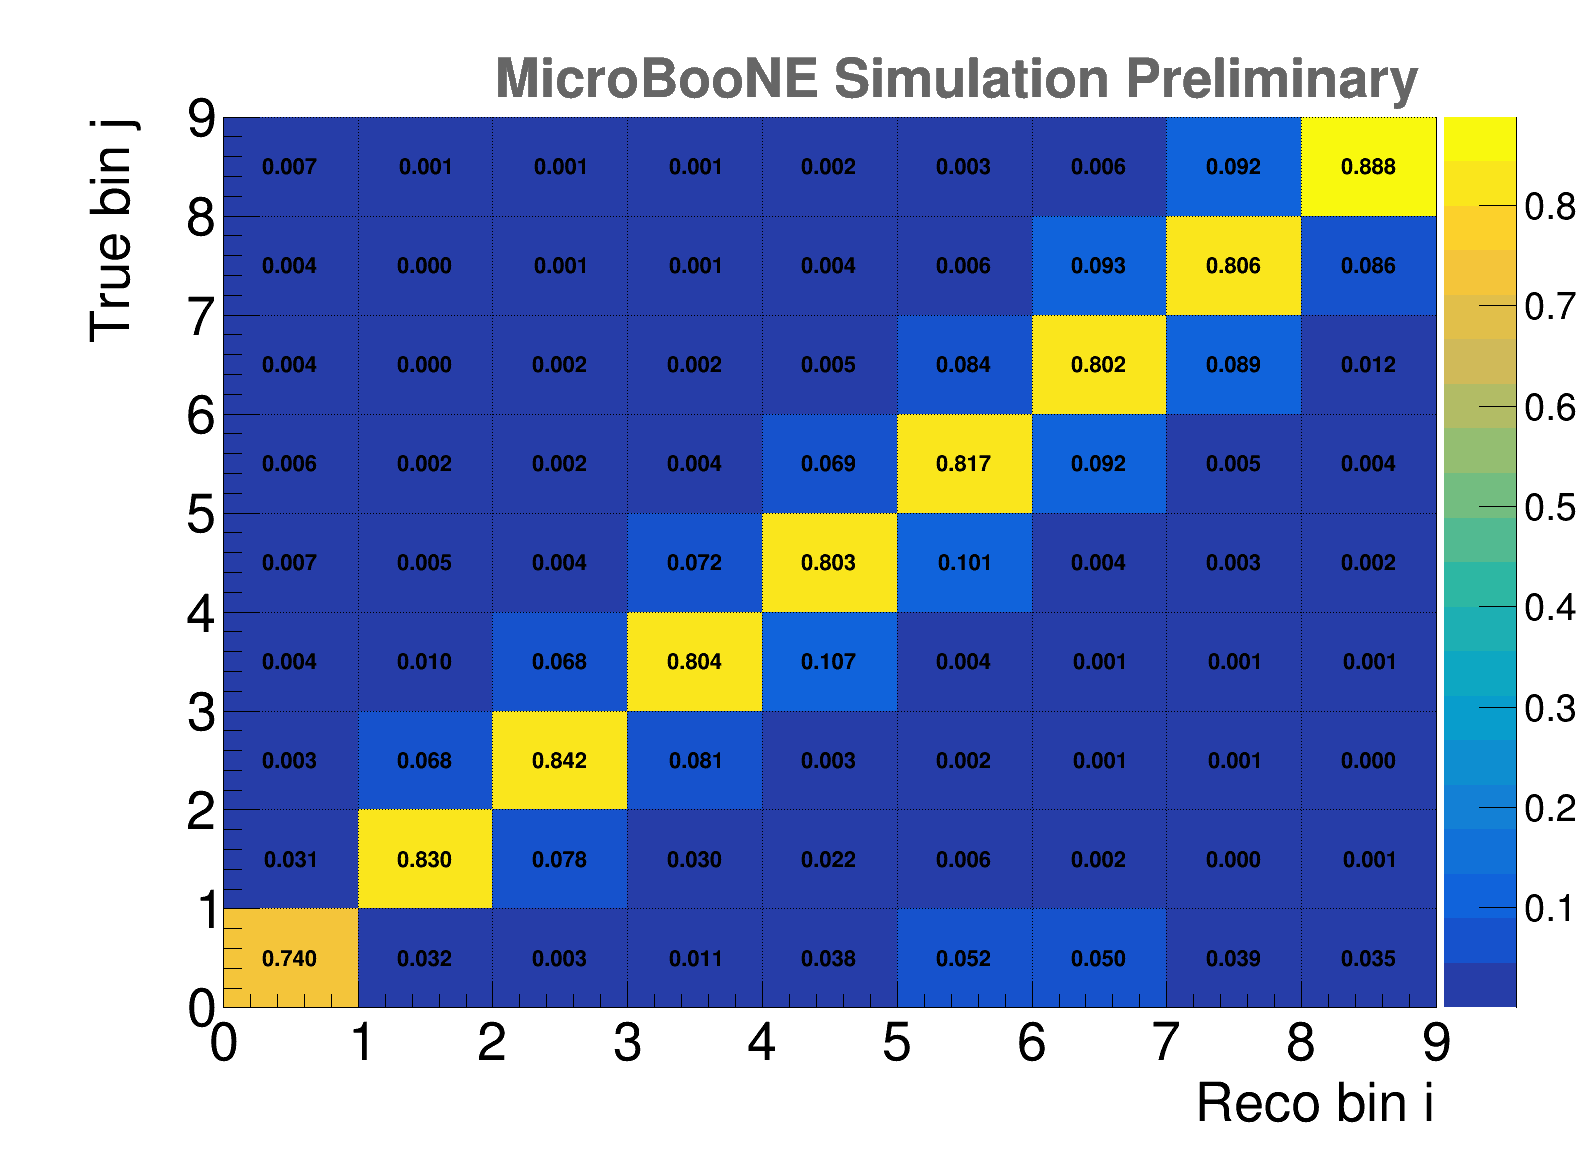

In [22]:
reco_entries = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ROOT.gStyle.SetPaintTextFormat("2.3f");
mitigation_matrix = np.zeros((9,9))
for j in range(1,binnum+1):
    for i in range(1,binnum+2):
        #print 'bin i,j: ', i,j,'Value: ',h_migration.GetBinContent(i,j)
        reco_entries[j-1]+=h_migration.GetBinContent(i,j)
h_mitigation_matrix = ROOT.TH2F("h_migration",'Migration matrix',9,0,9,9,0,9)
for j in range(1,binnum+1):
    for i in range(1,binnum+1):
        #print 'bin i,j: ', i,j,'Value: ',h_migration.GetBinContent(i,j)
        mitigation_matrix[i-1,j-1]= h_migration.GetBinContent(i,j)/reco_entries[j-1]
        h_mitigation_matrix.SetBinContent(i,j,mitigation_matrix[i-1,j-1])
        #print i-1,j-1,mitigation_matrix[i-1,j-1]
        #true_entries[j]+=h_migration.GetBinContent(i,j)
print mitigation_matrix
np.save(output_filedir+'migration_matrix_theta',mitigation_matrix)

h_mitigation_matrix.SetXTitle("Reco bin i")
h_mitigation_matrix.SetYTitle("True bin j")
h_mitigation_matrix.Draw('colz')
h_mitigation_matrix.Draw('same text')
h_mitigation_matrix.GetYaxis().SetTitleSize(0.05)
h_mitigation_matrix.GetYaxis().SetTitleOffset(0.0)
h_mitigation_matrix.GetYaxis().SetLabelSize(0.05)
h_mitigation_matrix.GetXaxis().SetTitleSize(0.05)
h_mitigation_matrix.GetXaxis().SetLabelSize(0.05)
h_mitigation_matrix.GetXaxis().SetTitleOffset(1)
h_mitigation_matrix.SetLineColor(ROOT.kBlack)
h_mitigation_matrix.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.1)
ROOT.gStyle.SetPaintTextFormat('0.3f')
prelim = draw_sim()
prelim.Draw()
c1.SetGrid(1)
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_mitigation_matrix_theta.png")
c1.SaveAs(globale.outputdir_root + "h_mitigation_matrix_theta.root")
c1.SaveAs(globale.outputdir_pdf + "h_mitigation_matrix_theta.pdf")

h_mitigation_matrix.Write("h_mitigation_matrix_theta")

307093.699219
307093.701172
161463.017578
161466.018066
0.525777695827
0.525787463078


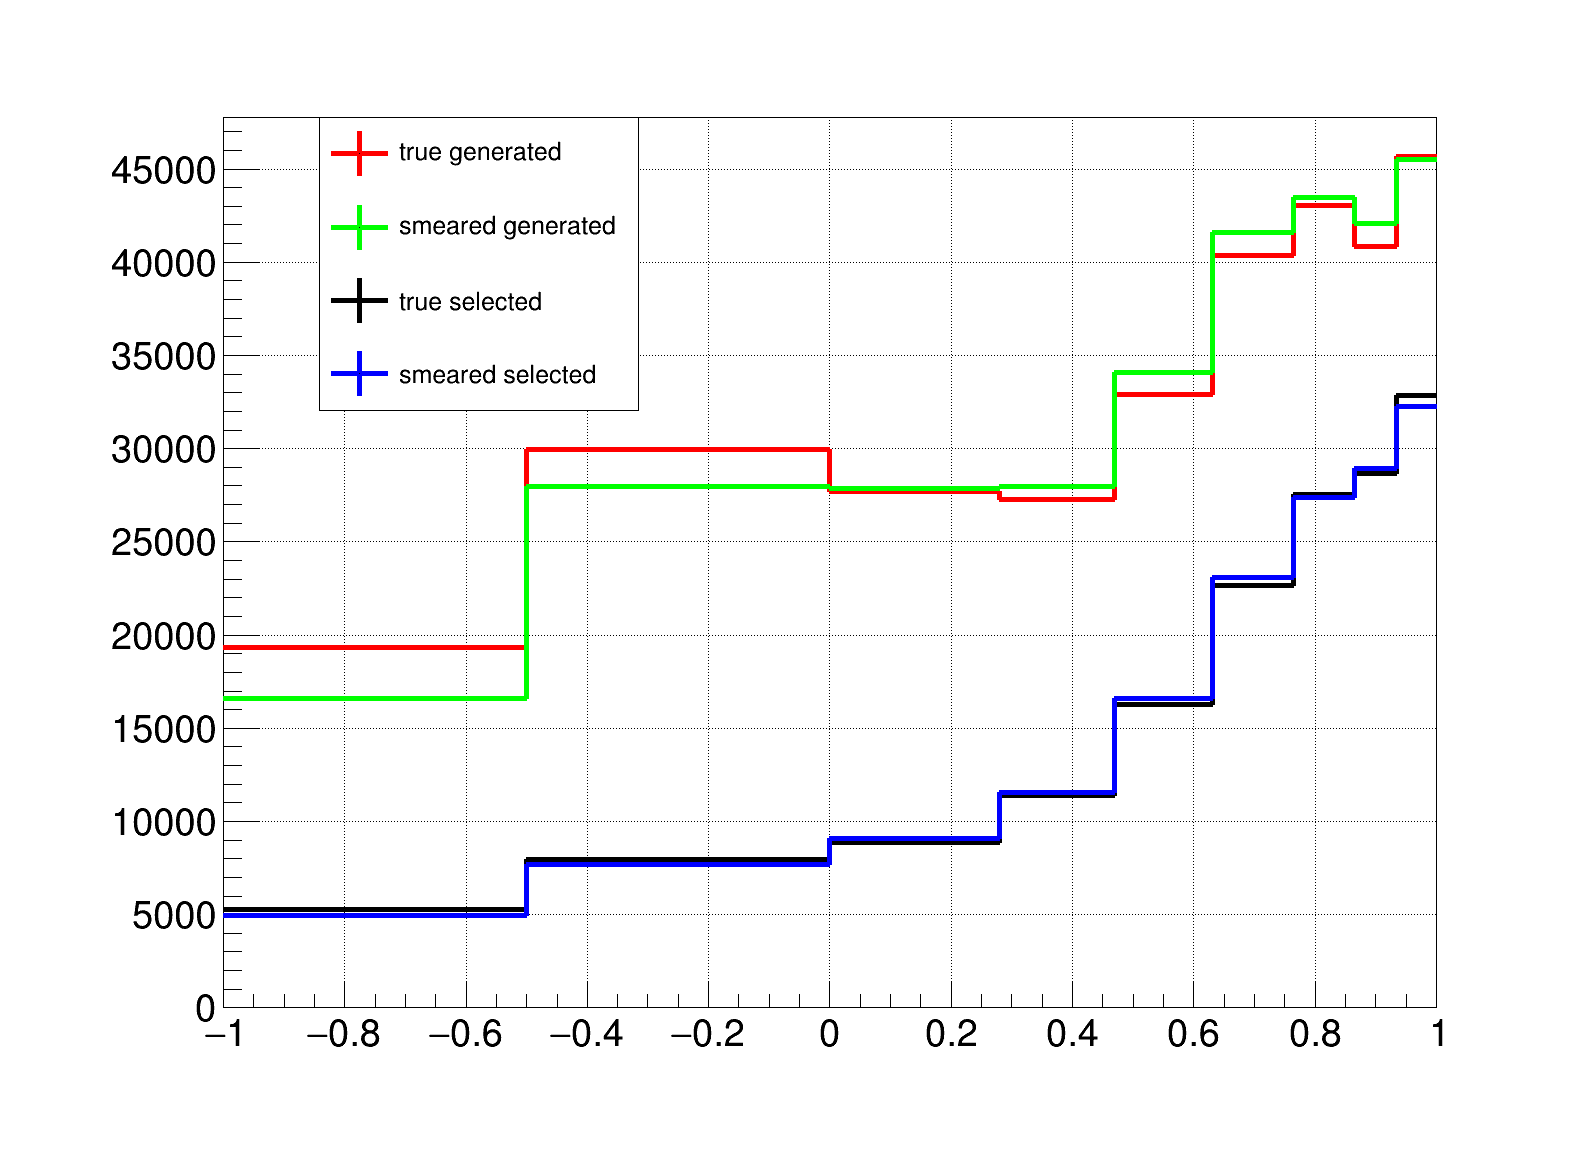

In [23]:
h_init_eff_energy_1.SetLineWidth(5)
h_init_eff_energy_1.SetLineColor(ROOT.kRed)
h_init_eff_energy_1.SetMinimum(0)
h_init_eff_energy.SetLineWidth(5)
h_init_eff_energy.SetLineColor(ROOT.kBlack)


gen_smeared = np.zeros((9))
sel_smeared = np.zeros((9))
for i in range(1,binnum+1):
    gen_smeared[i-1] = h_init_eff_energy_1.GetBinContent(i)
    sel_smeared[i-1] = h_init_eff_energy.GetBinContent(i)
gen_smeared = mitigation_matrix.dot(gen_smeared)
sel_smeared = mitigation_matrix.dot(sel_smeared)

h_init_eff_energy_1_sm = h_init_eff_energy_1.Clone()
h_init_eff_energy_sm = h_init_eff_energy_1.Clone()

for i in range(1,binnum+1):
    h_init_eff_energy_1_sm.SetBinContent(i,gen_smeared[i-1])
    h_init_eff_energy_sm.SetBinContent(i,sel_smeared[i-1])
    
h_init_eff_energy_1_sm.SetLineWidth(5)
h_init_eff_energy_1_sm.SetLineColor(ROOT.kGreen)
h_init_eff_energy_1_sm.SetMinimum(0)
h_init_eff_energy_sm.SetLineWidth(5)
h_init_eff_energy_sm.SetLineColor(ROOT.kBlue)

legend = ROOT.TLegend(0.2,0.65,0.4,0.9)
legend.AddEntry(h_init_eff_energy_1,'true generated',"lep");
legend.AddEntry(h_init_eff_energy_1_sm,'smeared generated',"lep");
legend.AddEntry(h_init_eff_energy,'true selected',"lep");
legend.AddEntry(h_init_eff_energy_sm,'smeared selected',"lep");

h_init_eff_energy_1_sm.Draw('hist')

h_init_eff_energy_1.Draw('same hist')
h_init_eff_energy.Draw('same hist')
h_init_eff_energy_1_sm.Draw('same hist')
h_init_eff_energy_sm.Draw('same hist')
legend.Draw()

print h_init_eff_energy_1.Integral(0,binnum+2)
print h_init_eff_energy_1_sm.Integral(0,binnum+2)

print h_init_eff_energy.Integral(0,binnum+2)
print h_init_eff_energy_sm.Integral(0,binnum+2)

print h_init_eff_energy.Integral(0,binnum+2)/h_init_eff_energy_1.Integral(0,binnum+2)
print h_init_eff_energy_sm.Integral(0,binnum+2)/h_init_eff_energy_1_sm.Integral(0,binnum+2)

c1.Draw()

In [24]:
# Nselected and N generated
title = 'MCS momentum efficiency'
weight_name = 'EventWeight*TunedCentralValue_Genie'
nenner_cut = 'numu_true'
zahler_cut = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && numu_signal'
h_init_eff_energy = ROOT.TH1F("h_init_eff_energy",title,binnum,array('f',mom_bins))
h_init_eff_energy_1 = ROOT.TH1F("h_init_eff_energy_1",title,binnum,array('f',mom_bins))
globale.overlay_out.Draw('cos(MCNu_leptonTheta)>>h_init_eff_energy',weight_name+'*('+zahler_cut+')')
globale.overlay_out.Draw('cos(MCNu_leptonTheta)>>h_init_eff_energy_1',weight_name+'*('+nenner_cut+')')
h_init_eff_energy.Write("h_eff_true_theta_z")
h_init_eff_energy_1.Write("h_eff_true_theta_n")

533

Warning in <TFile::Append>: Replacing existing TH1: h_init_eff_energy (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_init_eff_energy_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_init_eff_energy_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_init_eff_energy_1 (Potential memory leak).


In [25]:
# e tilde
N_sel = np.zeros((9))
N_gen = np.zeros((9))
for i in range(1,binnum+1):
    N_sel[i-1] = h_init_eff_energy.GetBinContent(i)
    N_gen[i-1] = h_init_eff_energy_1.GetBinContent(i)
    print N_sel[i-1],N_gen[i-1],N_sel[i-1]/N_gen[i-1]
eff_tilde = np.zeros((6))
eff_tilde = mitigation_matrix.dot(N_sel)/(mitigation_matrix.dot(N_gen))
print eff_tilde
np.save(outputdir+'eff_tilde_theta_xsec_CV',eff_tilde)

5292.48291015625 19357.96484375 0.2734007915023673
7981.33837890625 29967.484375 0.2663332790644443
8869.330078125 27689.94140625 0.3203087340633762
11400.53125 27248.6484375 0.41838887077828113
16266.5517578125 32911.76953125 0.49424725529775215
22645.5078125 40343.7109375 0.5613144474384658
27517.1015625 43037.4609375 0.6393755803220124
28648.712890625 40849.91015625 0.701316423488921
32838.4609375 45680.80859375 0.7188677685095295
[0.2982934  0.27469687 0.32518549 0.41369772 0.48629008 0.55513163
 0.62914157 0.68809612 0.70873364]


In [26]:
h_eff = h_init_eff_energy.Clone()
h_eff.Divide(h_init_eff_energy_1)

True

511

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/png/h_eff_tilde_xsecTheta.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/root/h_eff_tilde_xsecTheta.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/pdf/h_eff_tilde_xsecTheta.pdf has been created


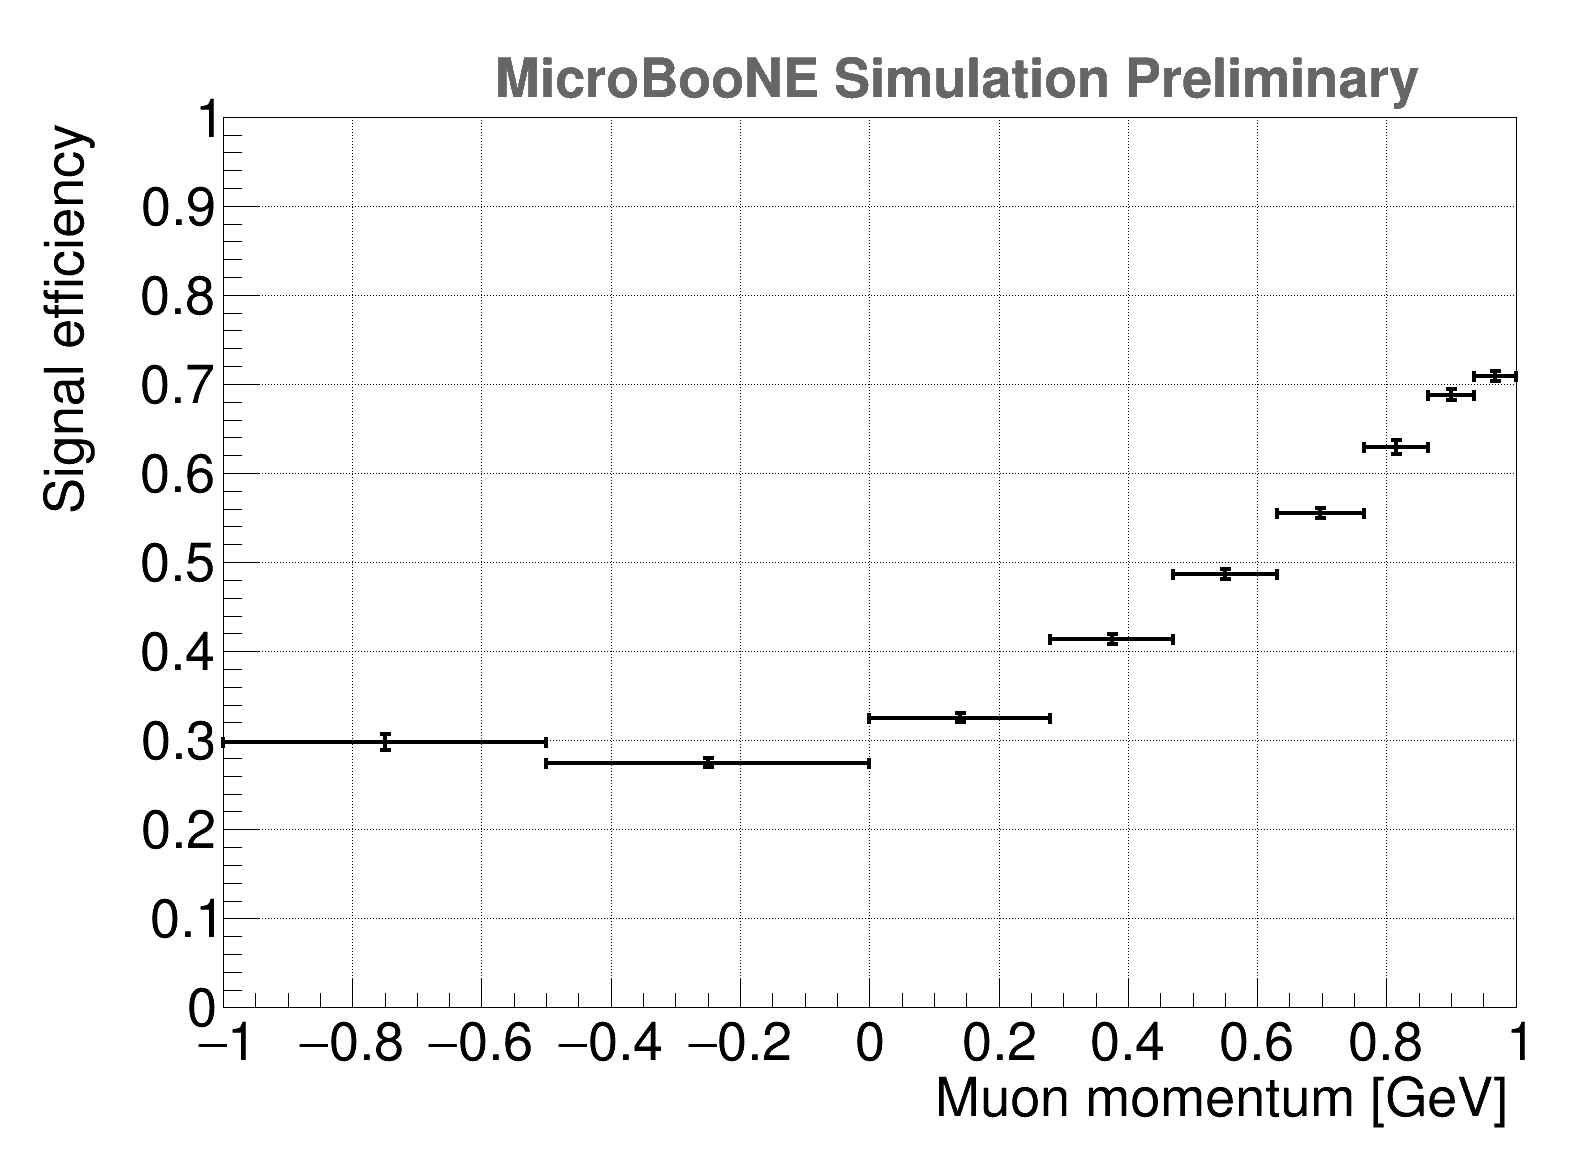

In [27]:
h_eff_tilde = ROOT.TH1F("h_eff_tilde",'Efficiency tilde',binnum,array('f',mom_bins))
for i in range(1,binnum+1):
    h_eff_tilde.SetBinContent(i,eff_tilde[i-1])
    h_eff_tilde.SetBinError(i,h_eff.GetBinError(i))
h_eff_tilde.SetMaximum(1)
h_eff_tilde.SetMinimum(0)
h_eff_tilde.SetLineWidth(3)

h_eff_tilde.SetXTitle("Muon momentum [GeV]")
h_eff_tilde.SetYTitle("Signal efficiency")
h_eff_tilde.GetYaxis().SetTitleSize(0.05)
h_eff_tilde.GetYaxis().SetTitleOffset(0.0)
h_eff_tilde.GetYaxis().SetLabelSize(0.05)
h_eff_tilde.GetXaxis().SetTitleSize(0.05)
h_eff_tilde.GetXaxis().SetLabelSize(0.05)
h_eff_tilde.GetXaxis().SetTitleOffset(1)
h_eff_tilde.SetLineColor(ROOT.kBlack)
h_eff_tilde.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.05)

h_eff_tilde.Draw('E1')
prelim = draw_sim()
prelim.Draw()
c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_eff_tilde_xsecTheta.png")
c1.SaveAs(globale.outputdir_root + "h_eff_tilde_xsecTheta.root")
c1.SaveAs(globale.outputdir_pdf + "h_eff_tilde_xsecTheta.pdf")

h_eff_tilde.Write("h_eff_tilde")

In [28]:
weight_name = 'EventWeight*TunedCentralValue_Genie'
variable = 'cos(TrackTheta)'
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'

h_data = ROOT.TH1F("h_data",'h_data',binnum,array('f',mom_bins))
h_ext = ROOT.TH1F("h_ext",'h_ext',binnum,array('f',mom_bins))
h_dirt = ROOT.TH1F("h_dirt",'h_dirt',binnum,array('f',mom_bins))
h_overlay = ROOT.TH1F("h_overlay",'h_overlay',binnum,array('f',mom_bins))
h_signal = ROOT.TH1F("h_signal",'h_signal',binnum,array('f',mom_bins))

#h_weight_func_n = ROOT.TH1F("h_weight_func_n",'h_weight_func',binnum,array('f',mom_bins))

globale.data_out.Draw(variable+'>>h_data',cut,'')
globale.ext_out.Draw(variable+'>>h_ext',cut,'')
globale.dirt_out.Draw(variable+'>>h_dirt',weight_name+'*('+cut+')','')
globale.overlay_out.Draw(variable+'>>h_overlay',weight_name+'*('+cut+'&& !numu_signal)','')
globale.overlay_out.Draw(variable+'>>h_signal',weight_name+'*('+cut+'&& numu_signal)','')


136504L

In [29]:
#lat = np.zeros(8,binnum)
for i in range(1,binnum+1):
    #print 'Entries in bin ',i,'-------------------------------------------------------------'
    n_da = h_data.GetBinContent(i)
    err_da = math.sqrt(n_da)
    n_ext = h_ext.GetBinContent(i)
    err_ext = math.sqrt(n_ext)
    n_dirt = h_dirt.GetBinContent(i)
    err_dirt = math.sqrt(n_dirt)
    n_ov = h_overlay.GetBinContent(i)
    err_ov = math.sqrt(n_ov)
    n_sig = h_signal.GetBinContent(i)
    err_sig = math.sqrt(n_sig)
    #print 'data: ',n_da, ' +- ',err_da,' Ext: ',n_ext,' +- ',err_ext,\
    #' Dirt: ',n_dirt,' +- ', err_dirt,' Overlay: ',n_ov,' +- ',err_ov,' Signal: ',n_sig,' +- ',err_sig
    #print ''
    #print 'data: {0:0.2f}'.format(n_da*scale[data]), ' +- {0:0.2f}'.format(err_da*scale[data])
    #print ' Ext: {0:0.2f}'.format(n_ext*scale[ext]),' +- {0:0.2f}'.format(err_ext*scale[ext])
    print i,' & {0:0.2f}'.format(n_da),' $\pm$ {0:0.2f}'.format(err_da),' & {0:0.2f}'.format(n_ext*scale[ext]),' $\pm$ {0:0.2f}'.format(err_ext*scale[ext]),\
    ' & {0:0.2f}'.format(n_dirt*scale[dirt]),' $\pm$ {0:0.2f}'.format(err_dirt*scale[dirt]),' & {0:0.2f}'.format(n_ov*scale[overlay]),' $\pm$ {0:0.2f}'.format(err_ov*scale[overlay]),\
    ' & {0:0.2f}'.format((n_ext*scale[ext]+n_dirt*scale[dirt]+n_ov*scale[overlay])),' $\pm$ {0:0.2f}'.format(math.sqrt(err_ext*err_ext*scale[ext]*scale[ext] + err_dirt*err_dirt*scale[dirt]*scale[dirt] + err_ov*err_ov*scale[overlay]*scale[overlay])),\
    ' & {0:0.2f}'.format(n_sig*scale[overlay]),' $\pm$ {0:0.2f}'.format(err_sig*scale[overlay]),\
    ' & {0:0.2f}'.format(n_da - (n_ext*scale[ext]+n_dirt*scale[dirt]+n_ov*scale[overlay])),' $\pm$ {0:0.2f}'.format(math.sqrt(err_da*err_da + err_ext*err_ext*scale[ext]*scale[ext] + err_dirt*err_dirt*scale[dirt]*scale[dirt] + err_ov*err_ov*scale[overlay]*scale[overlay]))
    #print ' Overlay: {0:0.2f}'.format(n_ov*scale[overlay]),' +- {0:0.2f}'.format(err_ov*scale[overlay])
    #print ' Signal: {0:0.2f}'.format(n_sig*scale[overlay]),' +- {0:0.2f}'.format(err_sig*scale[overlay])
    #print 'Total back ground: {0:0.2f}'.format(n_ext*scale[ext]+n_dirt*scale[dirt]+n_ov*scale[overlay]), ' +- {0:0.2f}'.format(math.sqrt(err_ext*err_ext*scale[ext]*scale[ext] + err_dirt*err_dirt*scale[dirt]*scale[dirt] + err_ov*err_ov*scale[overlay]*scale[overlay]))
    #print 'Total data - background: {0:0.2f}'.format(n_da - (n_ext*scale[ext]+n_dirt*scale[dirt]+n_ov*scale[overlay])), ' +- {0:0.2f}'.format( math.sqrt(err_da*err_da + err_ext*err_ext*scale[ext]*scale[ext] + err_dirt*err_dirt*scale[dirt]*scale[dirt] + err_ov*err_ov*scale[overlay]*scale[overlay]))
    #lat[i-1][0]=i
    
    
n_da = h_data.Integral(0,binnum+1)
err_da = math.sqrt(n_da)
n_ext = h_ext.Integral(0,binnum+1)
err_ext = math.sqrt(n_ext)
n_dirt = h_dirt.Integral(0,binnum+1)
err_dirt = math.sqrt(n_dirt)
n_ov = h_overlay.Integral(0,binnum+1)
err_ov = math.sqrt(n_ov)
n_sig = h_signal.Integral(0,binnum+1)
err_sig = math.sqrt(n_sig)
print 'For total cross section'

print 'tot & {0:0.2f}'.format(n_da),' $\pm$ {0:0.2f}'.format(err_da),' & {0:0.2f}'.format(n_ext*scale[ext]),' $\pm$ {0:0.2f}'.format(err_ext*scale[ext]),\
    ' & {0:0.2f}'.format(n_dirt*scale[dirt]),' $\pm$ {0:0.2f}'.format(err_dirt*scale[dirt]),' & {0:0.2f}'.format(n_ov*scale[overlay]),' $\pm$ {0:0.2f}'.format(err_ov*scale[overlay]),\
    ' & {0:0.2f}'.format((n_ext*scale[ext]+n_dirt*scale[dirt]+n_ov*scale[overlay])),' $\pm$ {0:0.2f}'.format(math.sqrt(err_ext*err_ext*scale[ext]*scale[ext] + err_dirt*err_dirt*scale[dirt]*scale[dirt] + err_ov*err_ov*scale[overlay]*scale[overlay])),\
    ' & {0:0.2f}'.format(n_sig*scale[overlay]),' $\pm$ {0:0.2f}'.format(err_sig*scale[overlay]),\
    ' & {0:0.2f}'.format(n_da - (n_ext*scale[ext]+n_dirt*scale[dirt]+n_ov*scale[overlay])),' $\pm$ {0:0.2f}'.format(math.sqrt(err_da*err_da + err_ext*err_ext*scale[ext]*scale[ext] + err_dirt*err_dirt*scale[dirt]*scale[dirt] + err_ov*err_ov*scale[overlay]*scale[overlay]))
    #
#print 'data: ',n_da, ' +- ',err_da,' Ext: ',n_ext,' +- ',err_ext,\
#' Dirt: ',n_dirt,' +- ', err_dirt,' Overlay: ',n_ov,' +- ',err_ov
#print ''
'''print 'data: ',n_da*scale[data], ' +- ',err_da*scale[data]
print ' Ext: ',n_ext*scale[ext],' +- ',err_ext*scale[ext],#\
print ' Dirt: ',n_dirt*scale[dirt],' +- ', err_dirt*scale[dirt]
print ' Overlay: ',n_ov*scale[overlay],' +- ',err_ov*scale[overlay]
print ' Signal: ',n_sig*scale[overlay],' +- ',err_sig*scale[overlay]

print 'Total back ground', n_ext*scale[ext]+n_dirt*scale[dirt]+n_ov*scale[overlay], ' +- ',math.sqrt(err_ext*err_ext*scale[ext]*scale[ext] + err_dirt*err_dirt*scale[dirt]*scale[dirt] + err_ov*err_ov*scale[overlay]*scale[overlay])
print 'Total data - background',n_da - (n_ext*scale[ext]+n_dirt*scale[dirt]+n_ov*scale[overlay]), ' +- ', math.sqrt(err_da*err_da + err_ext*err_ext*scale[ext]*scale[ext] + err_dirt*err_dirt*scale[dirt]*scale[dirt] + err_ov*err_ov*scale[overlay]*scale[overlay])
'''



1  & 88.00  $\pm$ 9.38  & 5.81  $\pm$ 0.75  & 11.43  $\pm$ 0.84  & 28.57  $\pm$ 0.41  & 45.81  $\pm$ 1.20  & 29.81  $\pm$ 0.42  & 42.19  $\pm$ 9.46
2  & 86.00  $\pm$ 9.27  & 14.52  $\pm$ 1.19  & 1.63  $\pm$ 0.32  & 16.60  $\pm$ 0.32  & 32.75  $\pm$ 1.27  & 46.33  $\pm$ 0.53  & 53.25  $\pm$ 9.36
3  & 101.00  $\pm$ 10.05  & 21.87  $\pm$ 1.46  & 1.76  $\pm$ 0.33  & 16.79  $\pm$ 0.32  & 40.42  $\pm$ 1.53  & 54.63  $\pm$ 0.57  & 60.58  $\pm$ 10.16
4  & 111.00  $\pm$ 10.54  & 24.49  $\pm$ 1.54  & 2.07  $\pm$ 0.36  & 16.96  $\pm$ 0.32  & 43.51  $\pm$ 1.61  & 69.69  $\pm$ 0.65  & 67.49  $\pm$ 10.66
5  & 139.00  $\pm$ 11.79  & 24.00  $\pm$ 1.52  & 2.04  $\pm$ 0.35  & 20.14  $\pm$ 0.35  & 46.18  $\pm$ 1.60  & 99.93  $\pm$ 0.78  & 92.82  $\pm$ 11.90
6  & 193.00  $\pm$ 13.89  & 22.55  $\pm$ 1.48  & 2.47  $\pm$ 0.39  & 22.49  $\pm$ 0.37  & 47.52  $\pm$ 1.57  & 139.15  $\pm$ 0.92  & 145.48  $\pm$ 13.98
7  & 204.00  $\pm$ 14.28  & 15.97  $\pm$ 1.24  & 2.50  $\pm$ 0.39  & 23.78  $\pm$ 0.38  & 42.25  $

"print 'data: ',n_da*scale[data], ' +- ',err_da*scale[data]\nprint ' Ext: ',n_ext*scale[ext],' +- ',err_ext*scale[ext],#print ' Dirt: ',n_dirt*scale[dirt],' +- ', err_dirt*scale[dirt]\nprint ' Overlay: ',n_ov*scale[overlay],' +- ',err_ov*scale[overlay]\nprint ' Signal: ',n_sig*scale[overlay],' +- ',err_sig*scale[overlay]\n\nprint 'Total back ground', n_ext*scale[ext]+n_dirt*scale[dirt]+n_ov*scale[overlay], ' +- ',math.sqrt(err_ext*err_ext*scale[ext]*scale[ext] + err_dirt*err_dirt*scale[dirt]*scale[dirt] + err_ov*err_ov*scale[overlay]*scale[overlay])\nprint 'Total data - background',n_da - (n_ext*scale[ext]+n_dirt*scale[dirt]+n_ov*scale[overlay]), ' +- ', math.sqrt(err_da*err_da + err_ext*err_ext*scale[ext]*scale[ext] + err_dirt*err_dirt*scale[dirt]*scale[dirt] + err_ov*err_ov*scale[overlay]*scale[overlay])\n"

In [30]:
h_data.Sumw2()
h_ext.Sumw2()
h_dirt.Sumw2()
h_overlay.Sumw2()
h_data.Scale(globale.scale[globale.data])
h_ext.Scale(globale.scale[globale.ext])
h_dirt.Scale(globale.scale[globale.dirt])
h_overlay.Scale(globale.scale[globale.overlay])

h_data.Write("h_data")
h_ext.Write("h_ext")
h_dirt.Write("h_dirt")
h_overlay.Write("h_overlay")

472

Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created


In [31]:
print h_overlay.GetSumOfWeights()
h_data.Add(h_ext,-1)
h_data.Add(h_dirt,-1)
h_data.Add(h_overlay,-1)
print h_data.GetSumOfWeights()

199.165092468
974.526054382


In [32]:
h_overlay_sig = ROOT.TH1F("h_overlay_sig",'h_overlay',binnum,array('f',mom_bins))
globale.overlay_out.Draw(variable+'>>h_overlay_sig',weight_name+'*('+cut+'&& numu_signal)','')
h_overlay_sig.Scale(globale.scale[globale.overlay])

h_overlay_sig_noTune = ROOT.TH1F("h_overlay_sig_noTune",'h_overlay_sig_noTune',binnum,array('f',mom_bins))
globale.overlay_out.Draw(variable+'>>h_overlay_sig_noTune','('+cut+'&& numu_signal)','')
h_overlay_sig_noTune.Scale(globale.scale[globale.overlay])


493

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/png/h_data_theta_bkgsubtracted.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/root/h_data_theta_bkgsubtracted.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/pdf/h_data_theta_bkgsubtracted.pdf has been created


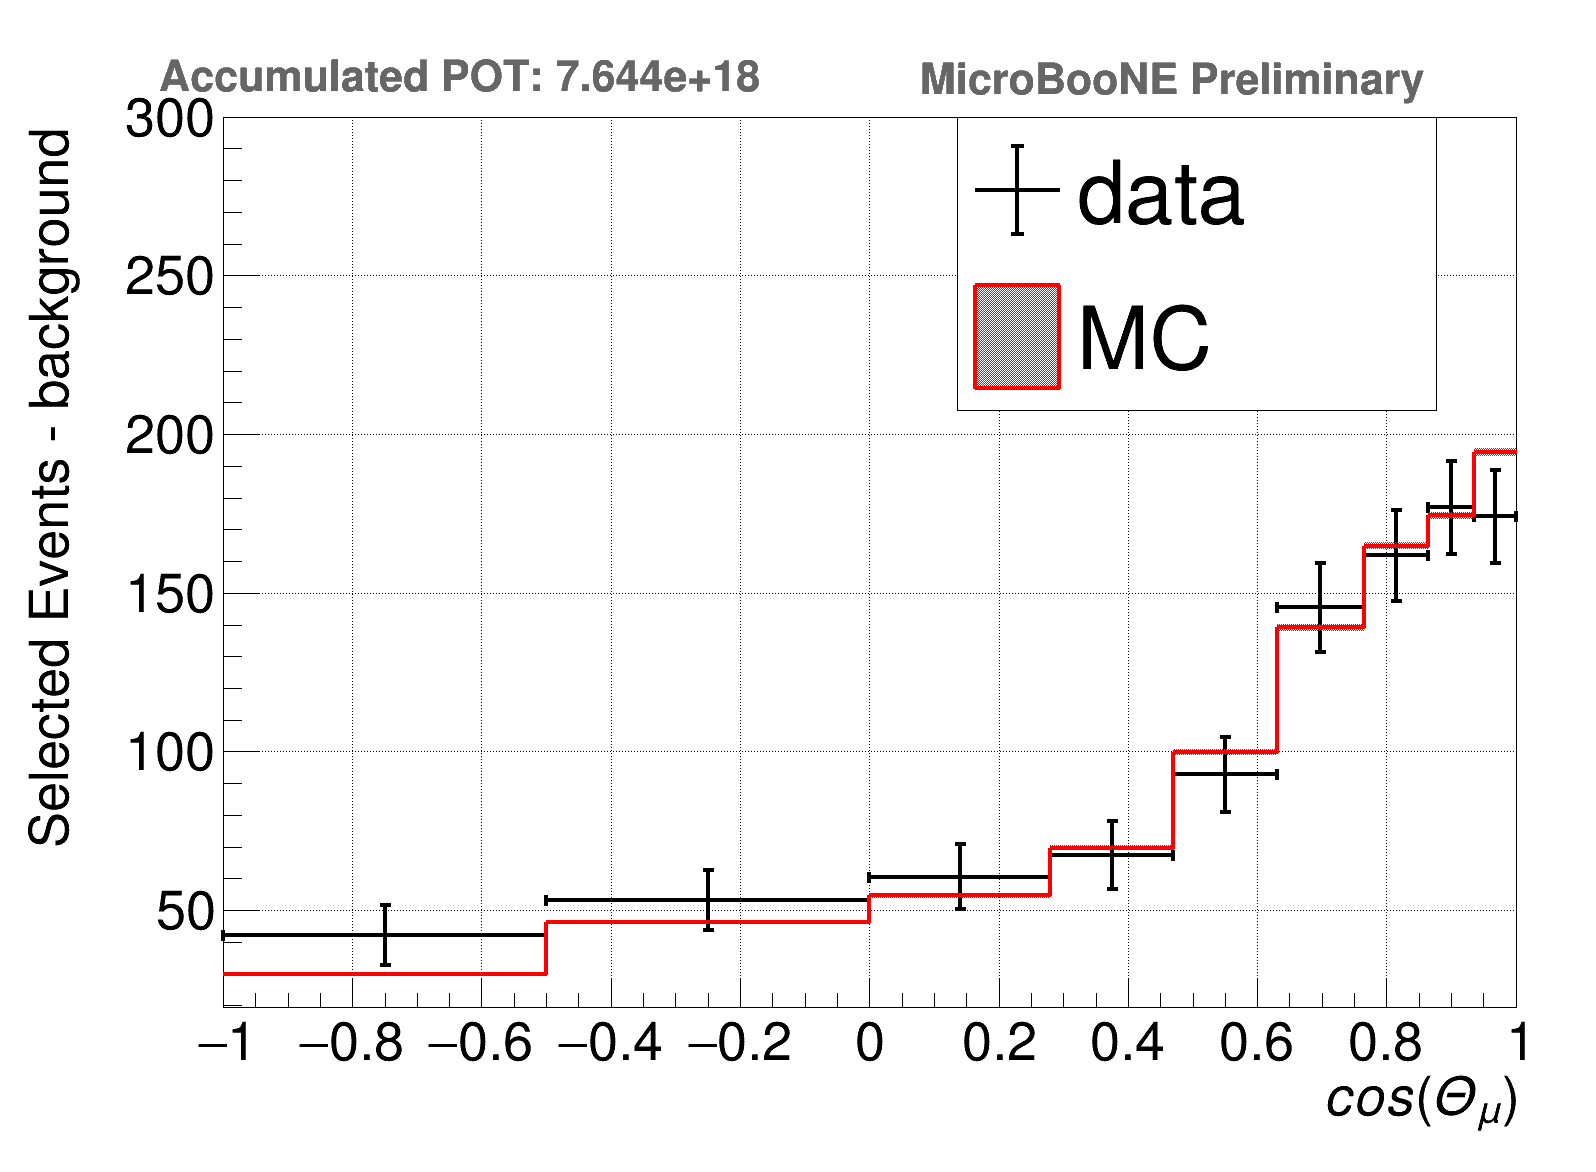

In [33]:
legend = ROOT.TLegend(0.6,0.65,0.9,0.9)
h_overlay_sig.SetLineColor(2)
legend.AddEntry(h_data,'data',"lep");
legend.AddEntry(h_overlay_sig,'MC',"f");
h_data.SetYTitle("Selected Events - background")
h_data.SetXTitle("cos(\Theta_{\mu})")
h_data.SetLineWidth(3)
h_data.SetMaximum(300)

h_data.GetYaxis().SetTitleSize(0.05)
h_data.GetYaxis().SetTitleOffset(0.0)
h_data.GetYaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleSize(0.05)
h_data.GetXaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleOffset(1)
h_data.SetLineColor(ROOT.kBlack)
h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.05)

h_data.Draw('E1')
h_overlay_sig.SetFillColor(0)
h_overlay_sig.SetLineWidth(4)
#h_overlay_sig.Draw('hist same')
h_overlay_sig.DrawCopy('Hist same')
h_overlay_sig.SetFillColor(2)
h_overlay_sig.SetFillStyle(3001)
h_overlay_sig.Draw('E2 same')
legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_data_theta_bkgsubtracted.png")
c1.SaveAs(outputdir_root + "h_data_theta_bkgsubtracted.root")
c1.SaveAs(outputdir_pdf + "h_data_theta_bkgsubtracted.pdf")

h_data.Write("h_data_theta_bkgsubtracted")
h_overlay_sig.Write("h_MC_theta_bkgsubtracted")

In [34]:
for i in range(1,binnum+1):
    h_data.SetBinContent(i,h_data.GetBinContent(i)/h_data.GetBinWidth(i))
    h_overlay_sig.SetBinContent(i,h_overlay_sig.GetBinContent(i)/h_overlay_sig.GetBinWidth(i))
    h_data.SetBinError(i,h_data.GetBinError(i)/h_data.GetBinWidth(i))
    h_overlay_sig.SetBinError(i,h_overlay_sig.GetBinError(i)/h_overlay_sig.GetBinWidth(i))
    h_overlay_sig_noTune.SetBinContent(i,h_overlay_sig_noTune.GetBinContent(i)/h_overlay_sig_noTune.GetBinWidth(i))
    h_overlay_sig_noTune.SetBinError(i,h_overlay_sig_noTune.GetBinError(i)/h_overlay_sig_noTune.GetBinWidth(i))
    print h_data.GetBinContent(i)/h_data.GetBinWidth(i)

168.775268555
213.009063721
772.64365821
1869.5282217
3625.72105882
7982.66115419
16175.3611337
36098.1168302
41201.8682481


493

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/png/h_data_theta_bkgsubtracted_binwidth.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/root/h_data_theta_bkgsubtracted_binwidth.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/pdf/h_data_theta_bkgsubtracted_binwidth.pdf has been created


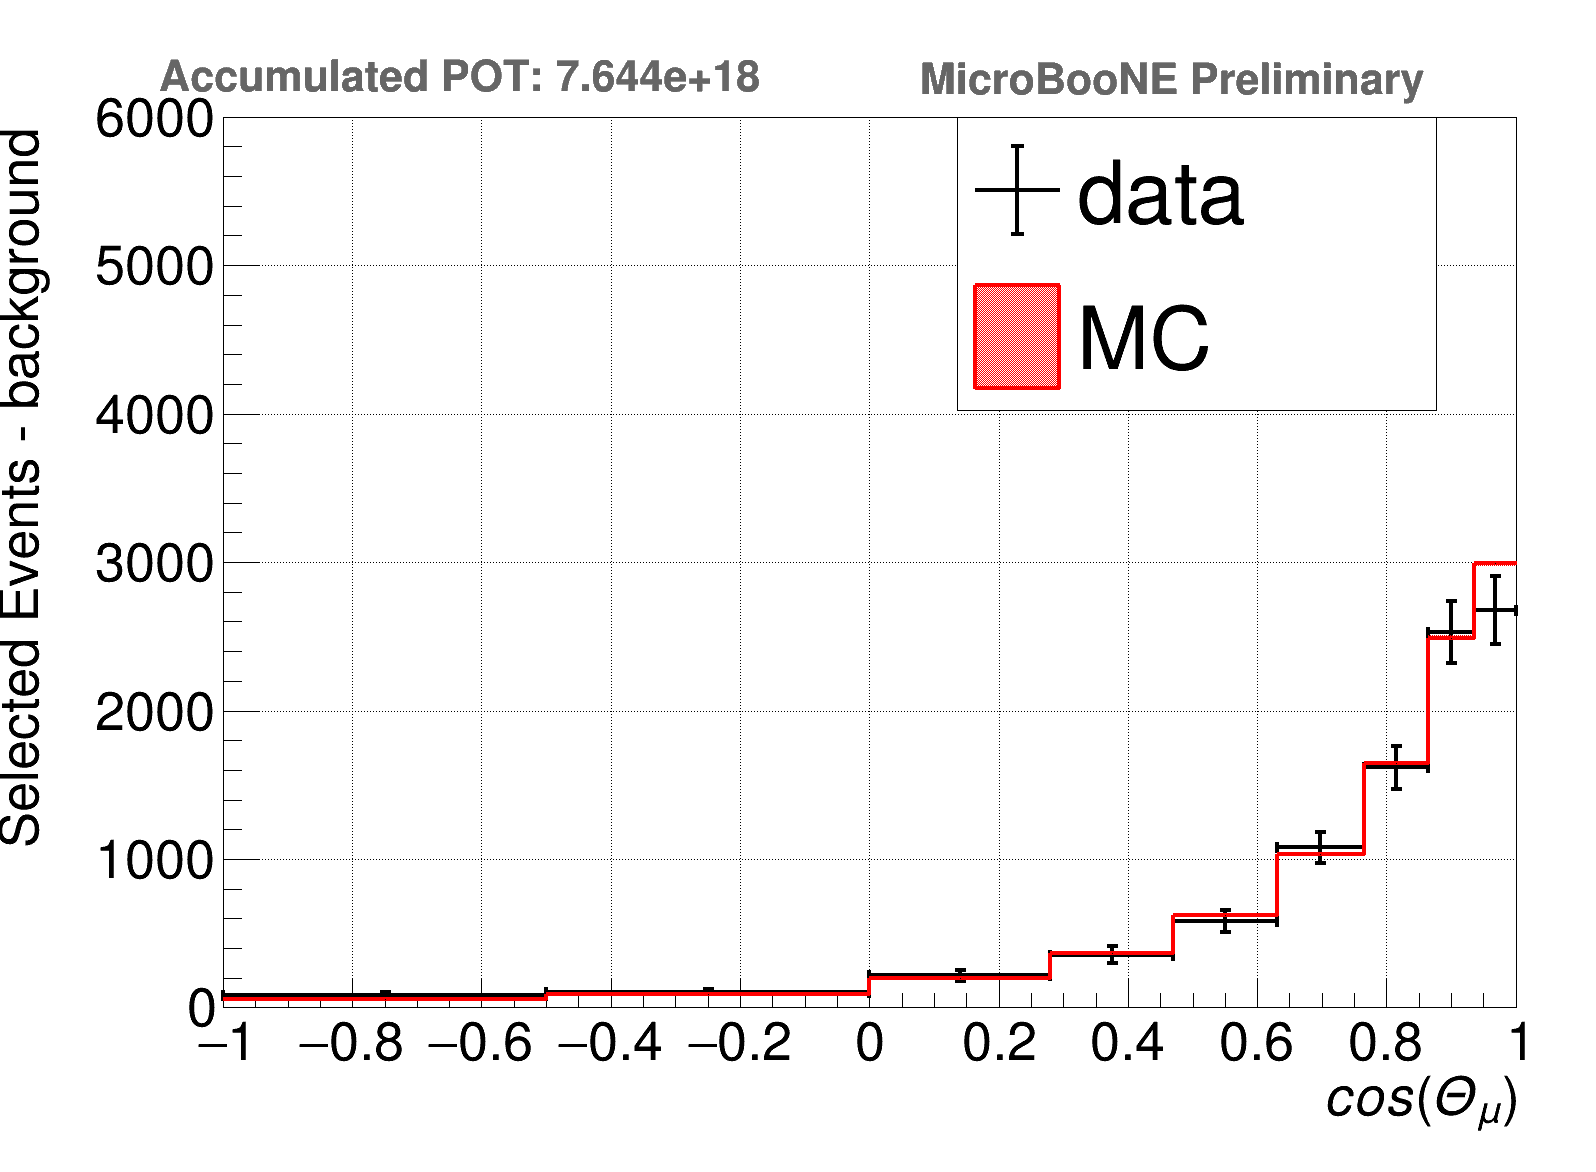

In [35]:
legend = ROOT.TLegend(0.6,0.65,0.9,0.9)
h_overlay_sig.SetLineColor(2)
legend.AddEntry(h_data,'data',"lep");
legend.AddEntry(h_overlay_sig,'MC',"f");
h_data.SetYTitle("Selected Events - background")
h_data.SetXTitle("cos(\Theta_{\mu})")
h_data.SetLineWidth(3)
h_data.SetMaximum(6000)

h_data.GetYaxis().SetTitleSize(0.05)
h_data.GetYaxis().SetTitleOffset(0.0)
h_data.GetYaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleSize(0.05)
h_data.GetXaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleOffset(1)
h_data.SetLineColor(ROOT.kBlack)
h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.05)

h_data.Draw('E1')
h_overlay_sig.SetFillColor(0)
h_overlay_sig.SetLineWidth(4)
#h_overlay_sig.Draw('hist same')
h_overlay_sig.DrawCopy('Hist same')
h_overlay_sig.SetFillColor(2)
h_overlay_sig.SetFillStyle(3001)
h_overlay_sig.Draw('E2 same')
legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_data_theta_bkgsubtracted_binwidth.png")
c1.SaveAs(outputdir_root + "h_data_theta_bkgsubtracted_binwidth.root")
c1.SaveAs(outputdir_pdf + "h_data_theta_bkgsubtracted_binwidth.pdf")

h_data.Write("h_data_theta_bkgsubtracted_binwidth")
h_overlay_sig.Write("h_MC_theta_bkgsubtracted_binwidth")

In [36]:
 # cos(MCNu_leptonTheta):cos(TrackTheta)
h_true = ROOT.TH1F("h_true",'h_true',binnum,array('f',mom_bins))
globale.overlay_out.Draw('cos(MCNu_leptonTheta)'+'>>h_true',weight_name+'*(numu_true)','')

h_true_tot = ROOT.TH1F("h_true_tot",'h_true_tot',binnum,array('f',mom_bins))
globale.overlay_out.Draw('cos(MCNu_leptonTheta)'+'>>h_true_tot',weight_name+'*(numu_true)','')

h_eff_test = h_true.Clone()
h_eff_test.Divide(h_true_tot)

h_true.Scale(globale.scale[globale.overlay])
h_true.SetLineColor(ROOT.kOrange)
h_true.SetLineWidth(4)

#h_true.Divide(h_eff_test)

h_true_smeare = h_true.Clone()
true_bins = np.zeros((9))
for i in range(1,binnum+1):
    true_bins[i-1] = h_true.GetBinContent(i)
    
true_bins_smeared = np.zeros((binnum+1))

true_bins_smeared = mitigation_matrix.dot(true_bins)
#sel_smeared = mitigation_matrix.dot(sel_smeared)


for i in range(1,binnum+1):
    h_true_smeare.SetBinContent(i,true_bins_smeared[i-1])
    print true_bins_smeared[i-1]
    print 'Eff: ',h_eff_test.GetBinContent(i)
h_true_smeare.SetLineColor(ROOT.kGreen)
h_true_smeare.SetLineWidth(4)



99.93763247960611
Eff:  1.0
168.6463467862433
Eff:  1.0
168.00824267364624
Eff:  1.0
168.46269646845653
Eff:  1.0
205.49750243536562
Eff:  1.0
250.6653944615413
Eff:  1.0
262.07927014317704
Eff:  1.0
253.48104206988037
Eff:  1.0
274.2949544522983
Eff:  1.0


In [37]:
h_data.Divide(h_eff_tilde)
h_data.Scale(1.0/(N_tot*beam_flux*1e-38))

h_overlay_sig.Divide(h_eff_tilde)
h_overlay_sig.Scale(1.0/(N_tot*beam_flux*1e-38))

h_overlay_sig_noTune.Divide(h_eff_tilde)
h_overlay_sig_noTune.Scale(1.0/(N_tot*beam_flux*1e-38))

h_true.Scale(1.0/(N_tot*beam_flux*1e-38))
h_true_smeare.Scale(1.0/(N_tot*beam_flux*1e-38))

In [38]:
for i in range(1,binnum+1):
    #h_data.SetBinContent(i,h_data.GetBinContent(i)/h_data.GetBinWidth(i))
    #h_overlay_sig.SetBinContent(i,h_overlay_sig.GetBinContent(i)/h_overlay_sig.GetBinWidth(i))
    #h_data.SetBinError(i,h_data.GetBinError(i)/h_data.GetBinWidth(i))
    #h_overlay_sig.SetBinError(i,h_overlay_sig.GetBinError(i)/h_overlay_sig.GetBinWidth(i))
    h_true.SetBinContent(i,h_true.GetBinContent(i)/h_true.GetBinWidth(i))
    h_true.SetBinError(i,h_true.GetBinError(i)/h_true.GetBinWidth(i))
    h_true_smeare.SetBinContent(i,h_true_smeare.GetBinContent(i)/h_true_smeare.GetBinWidth(i))
    h_true_smeare.SetBinError(i,h_true_smeare.GetBinError(i)/h_true_smeare.GetBinWidth(i))

    print h_data.GetBinContent(i)/h_data.GetBinWidth(i)

0.244463354349
0.335037142038
1.02658931261
1.95252913491
3.22142213333
6.2129859545
11.1084696988
22.6664804731
25.117851225


In [39]:

h_QE = ROOT.TH1F("h_QE",'h_QE',binnum,array('f',mom_bins))
h_MEC = ROOT.TH1F("h_MEC",'h_MEC',binnum,array('f',mom_bins))
h_RES = ROOT.TH1F("h_RES",'h_RES',binnum,array('f',mom_bins))
h_DIS = ROOT.TH1F("h_DIS",'h_DIS',binnum,array('f',mom_bins))

globale.overlay_out.Draw(variable+'>>h_QE',weight_name+'*('+cut+'&& numu_signal && MCNu_Interaction==0)','')
globale.overlay_out.Draw(variable+'>>h_MEC',weight_name+'*('+cut+'&& numu_signal && MCNu_Interaction==10)','')
globale.overlay_out.Draw(variable+'>>h_RES',weight_name+'*('+cut+'&& numu_signal && MCNu_Interaction==1)','')
globale.overlay_out.Draw(variable+'>>h_DIS',weight_name+'*('+cut+'&& numu_signal && MCNu_Interaction==2)','')

list_histo = [h_QE,h_MEC,h_RES,h_DIS]

for x in list_histo:
    x.Scale(globale.scale[globale.overlay])
    x.Divide(h_eff_tilde)
    x.Scale(1.0/(N_tot*beam_flux*1e-38))
    x.SetLineWidth(4)
    for i in range(1,binnum+1):
        x.SetBinContent(i,x.GetBinContent(i)/x.GetBinWidth(i))
        x.SetBinError(i,x.GetBinError(i)/x.GetBinWidth(i))
        
h_QE.SetLineColor(ROOT.kGreen+2)
h_MEC.SetLineColor(ROOT.kOrange-3)
h_RES.SetLineColor(ROOT.kRed+1)
h_DIS.SetLineColor(ROOT.kBlue+1)



Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/png/h_xsec_corr_theta_channel.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/root/h_xsec_corr_theta_channel.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/pdf/h_xsec_corr_theta_channel.pdf has been created


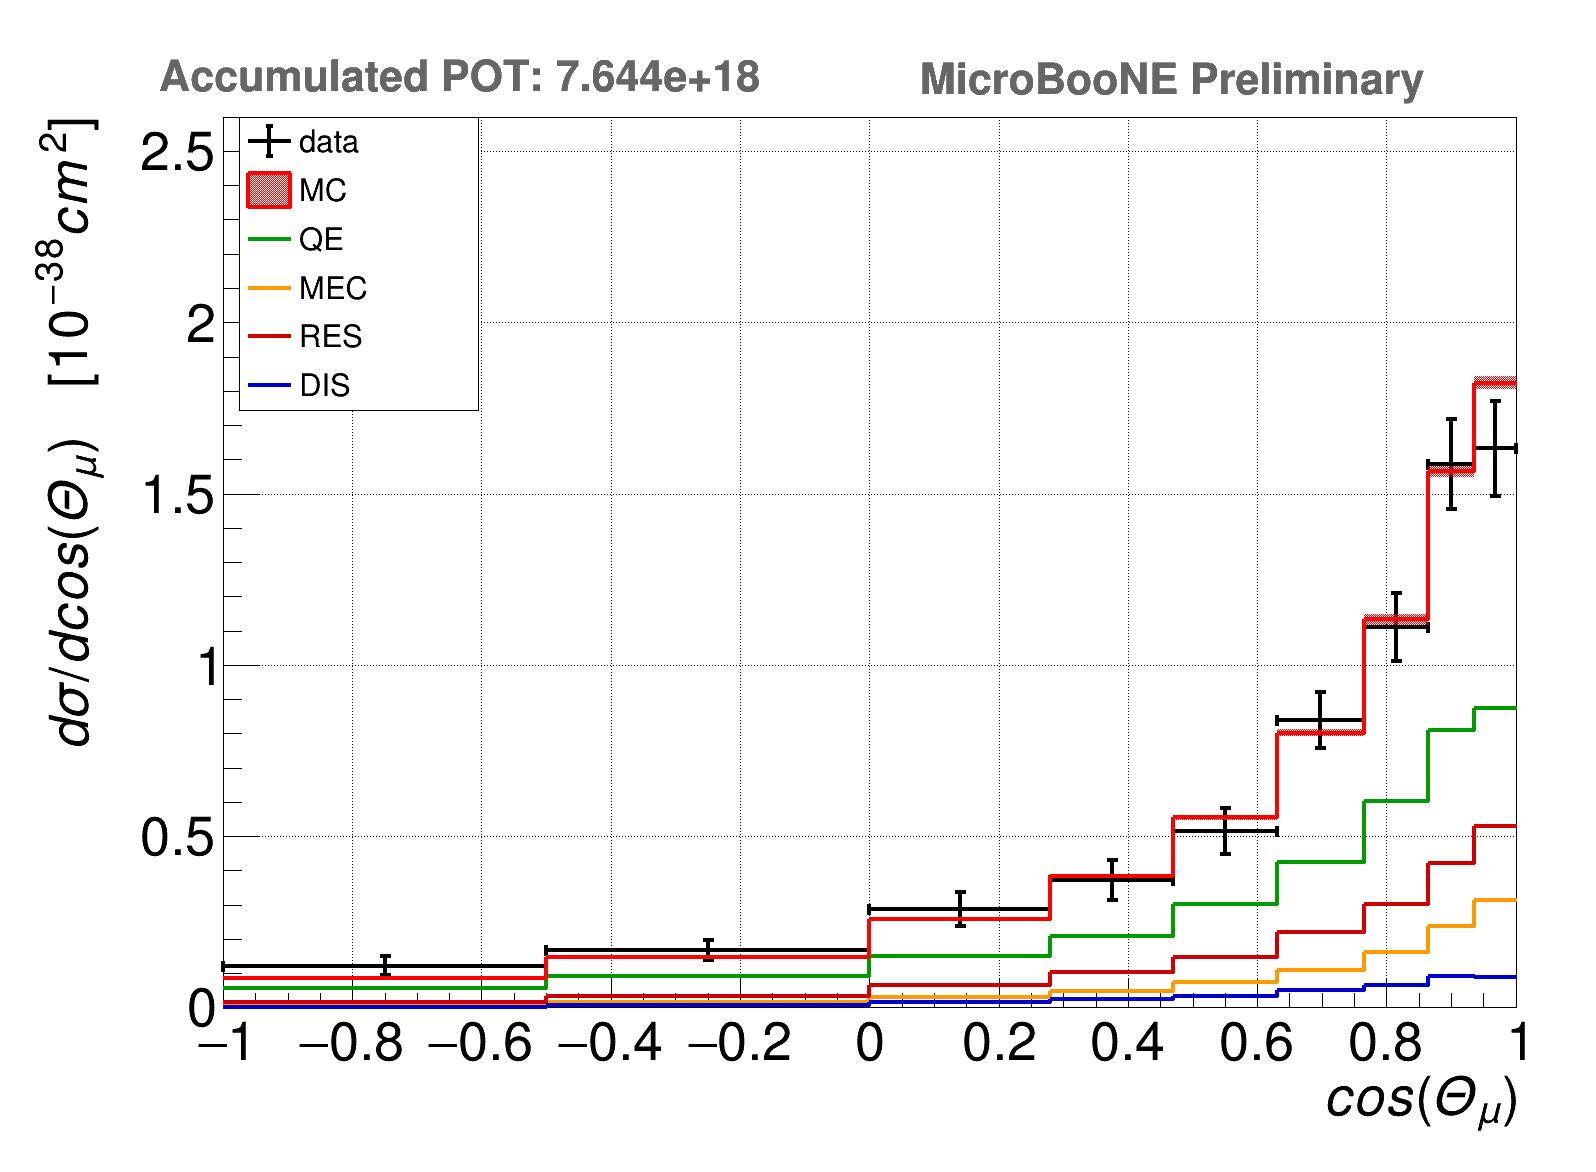

In [40]:
legend = ROOT.TLegend(0.15,0.65,0.3,0.9)
h_overlay_sig.SetLineColor(2)
legend.AddEntry(h_data,'data',"lep");
legend.AddEntry(h_overlay_sig,'MC',"f");
legend.AddEntry(h_QE,'QE',"l");
legend.AddEntry(h_MEC,'MEC',"l");
legend.AddEntry(h_RES,'RES',"l");
legend.AddEntry(h_DIS,'DIS',"l");
h_data.SetYTitle("d\sigma / dcos(\Theta_{\mu}) \t [10^{-38} cm^{2}]")
h_data.SetXTitle("cos(\Theta_{\mu})")
h_data.SetLineWidth(3)

h_data.GetYaxis().SetTitleSize(0.05)
h_data.GetYaxis().SetTitleOffset(0.0)
h_data.GetYaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleSize(0.05)
h_data.GetXaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleOffset(1)
h_data.SetMaximum(2.6)
h_data.SetMinimum(0)
h_data.SetLineColor(ROOT.kBlack)
h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.05)

h_data.Draw('E1')

h_QE.Draw('hist same')
h_MEC.Draw('hist same')
h_RES.Draw('hist same')
h_DIS.Draw('hist same')

h_overlay_sig.SetFillColor(0)
h_overlay_sig.SetLineWidth(4)
#h_overlay_sig.Draw('hist same')
h_overlay_sig.DrawCopy('Hist same')
h_overlay_sig.SetFillColor(2)
h_overlay_sig.SetFillStyle(3001)
h_overlay_sig.Draw('E2 same')
legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_xsec_corr_theta_channel.png")
c1.SaveAs(outputdir_root + "h_xsec_corr_theta_channel.root")
c1.SaveAs(outputdir_pdf + "h_xsec_corr_theta_channel.pdf")

#h_data.Write("h_xsec_data_theta_channel")
#h_overlay_sig.Write("h_xsec_MC_theta_channel")

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/png/h_xsec_corr_theta_channel_stacked.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/root/h_xsec_corr_theta_channel_stacked.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/pdf/h_xsec_corr_theta_channel_stacked.pdf has been created


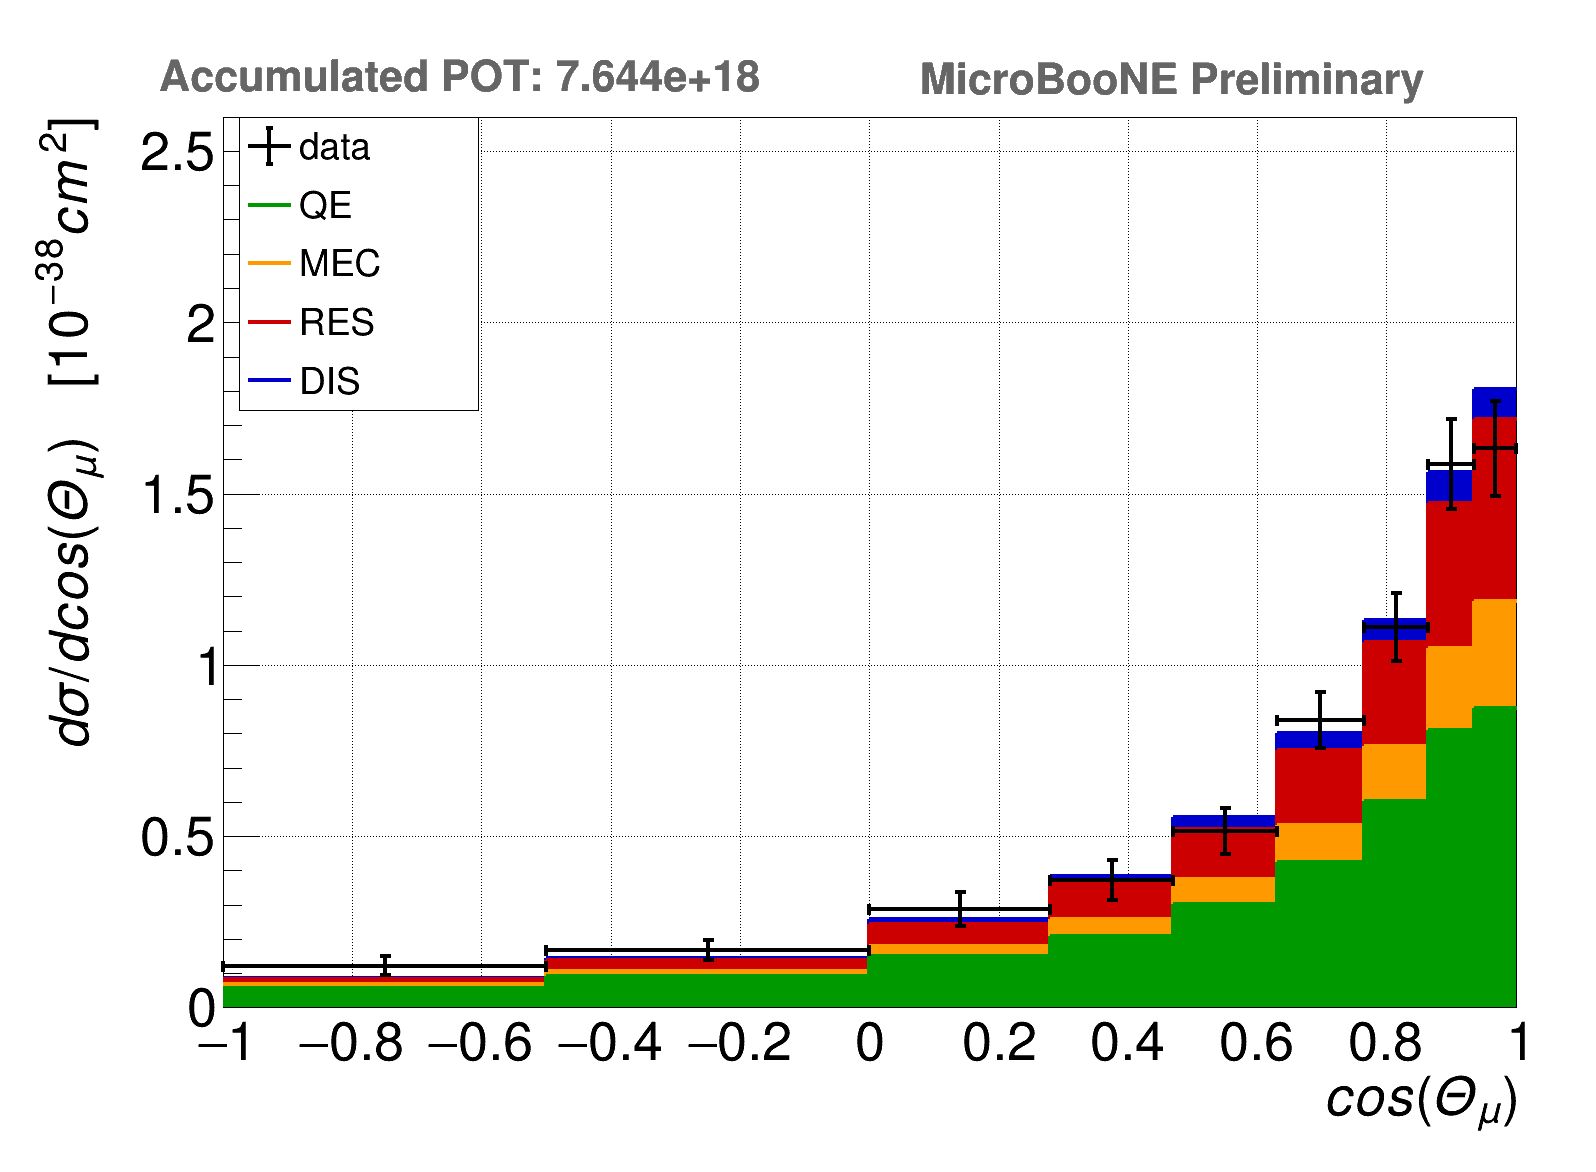

In [41]:
legend = ROOT.TLegend(0.15,0.65,0.3,0.9)
h_overlay_sig.SetLineColor(2)
legend.AddEntry(h_data,'data',"lep");
legend.AddEntry(h_QE,'QE',"l");
legend.AddEntry(h_MEC,'MEC',"l");
legend.AddEntry(h_RES,'RES',"l");
legend.AddEntry(h_DIS,'DIS',"l");h_data.SetYTitle("d\sigma / dcos(\Theta_{\mu}) \t [10^{-38} cm^{2}]")
h_data.SetXTitle("cos(\Theta_{\mu})")
h_data.SetLineWidth(3)

h_data.GetYaxis().SetTitleSize(0.05)
h_data.GetYaxis().SetTitleOffset(0.0)
h_data.GetYaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleSize(0.05)
h_data.GetXaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleOffset(1)
h_data.SetMaximum(2.6)
h_data.SetMinimum(0)
h_data.SetLineColor(ROOT.kBlack)
h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.05)

h_data.Draw('E1')

hs = ROOT.THStack("hs",'variable'+';'+'axis_name'+'; Entries per bin');
h_DIS.SetFillColor(ROOT.kBlue+1)
h_RES.SetFillColor(ROOT.kRed+1)
h_MEC.SetFillColor(ROOT.kOrange-3)
h_QE.SetFillColor(ROOT.kGreen+2)
hs.Add(h_QE)
hs.Add(h_MEC)
hs.Add(h_RES)
hs.Add(h_DIS)

hs.Draw('hist same')
h_data.Draw('E1 same')

legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_xsec_corr_theta_channel_stacked.png")
c1.SaveAs(outputdir_root + "h_xsec_corr_theta_channel_stacked.root")
c1.SaveAs(outputdir_pdf + "h_xsec_corr_theta_channel_stacked.pdf")

#h_data.Write("h_xsec_data_theta_channel")
#h_overlay_sig.Write("h_xsec_MC_theta_channel")

509

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/png/h_xsec_corr_theta.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/root/h_xsec_corr_theta.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/pdf/h_xsec_corr_theta.pdf has been created


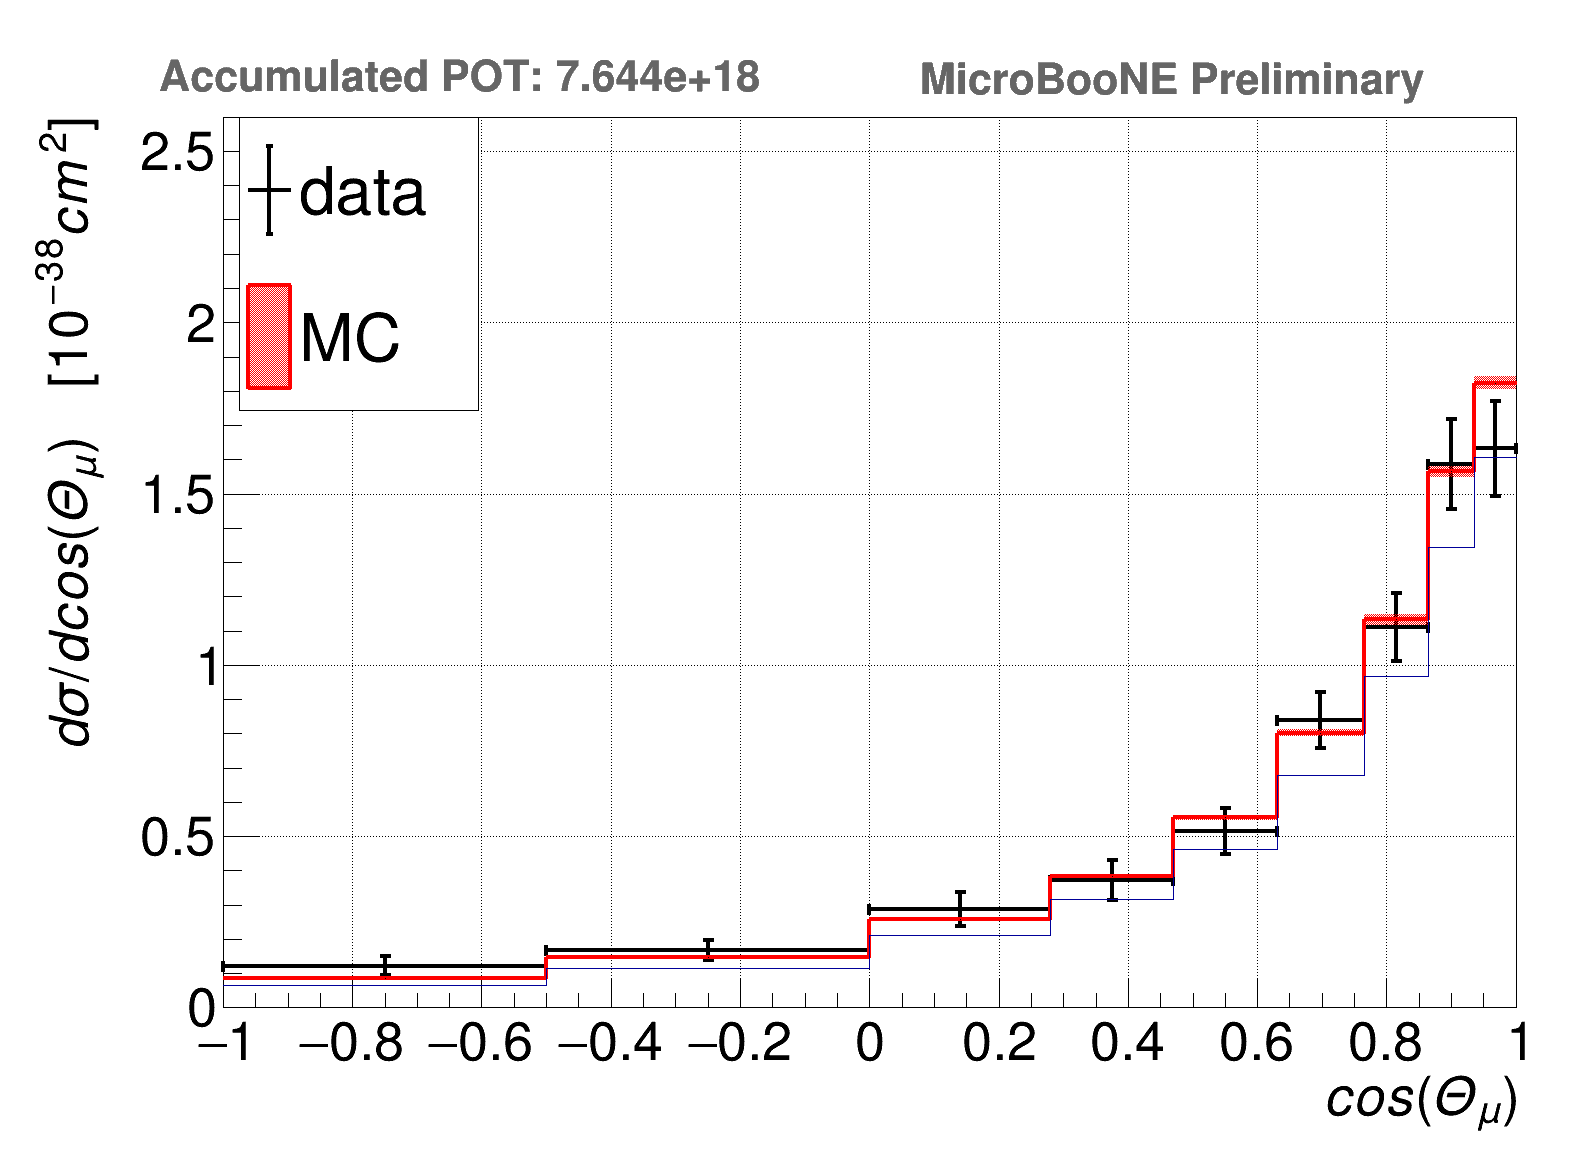

In [42]:
legend = ROOT.TLegend(0.15,0.65,0.3,0.9)
h_overlay_sig.SetLineColor(2)
legend.AddEntry(h_data,'data',"lep");
legend.AddEntry(h_overlay_sig,'MC',"f");
h_data.SetYTitle("d\sigma / dcos(\Theta_{\mu}) \t [10^{-38} cm^{2}]")
h_data.SetXTitle("cos(\Theta_{\mu})")
h_data.SetLineWidth(3)

h_data.GetYaxis().SetTitleSize(0.05)
h_data.GetYaxis().SetTitleOffset(0.0)
h_data.GetYaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleSize(0.05)
h_data.GetXaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleOffset(1)
h_data.SetMaximum(2.6)
h_data.SetMinimum(0)
h_data.SetLineColor(ROOT.kBlack)
h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.05)

h_data.Draw('E1')
h_overlay_sig.SetFillColor(0)
h_overlay_sig.SetLineWidth(4)
#h_overlay_sig.Draw('hist same')
h_overlay_sig.DrawCopy('Hist same')
h_overlay_sig.SetFillColor(2)
h_overlay_sig.SetFillStyle(3001)
h_overlay_sig.Draw('E2 same')
h_overlay_sig_noTune.Draw('same hist')

legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
c1.Draw()
c1.SaveAs(outputdir_png + "h_xsec_corr_theta.png")
c1.SaveAs(outputdir_root + "h_xsec_corr_theta.root")
c1.SaveAs(outputdir_pdf + "h_xsec_corr_theta.pdf")

h_data.Write("h_xsec_data_theta")
h_overlay_sig.Write("h_xsec_MC_theta")
h_overlay_sig_noTune.Write('h_xsec_MC_theta_noTune')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/png/h_xsec_corr_theta_ratio.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/root/h_xsec_corr_theta_ratio.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_theta_weightedV4/pdf/h_xsec_corr_theta_ratio.pdf has been created


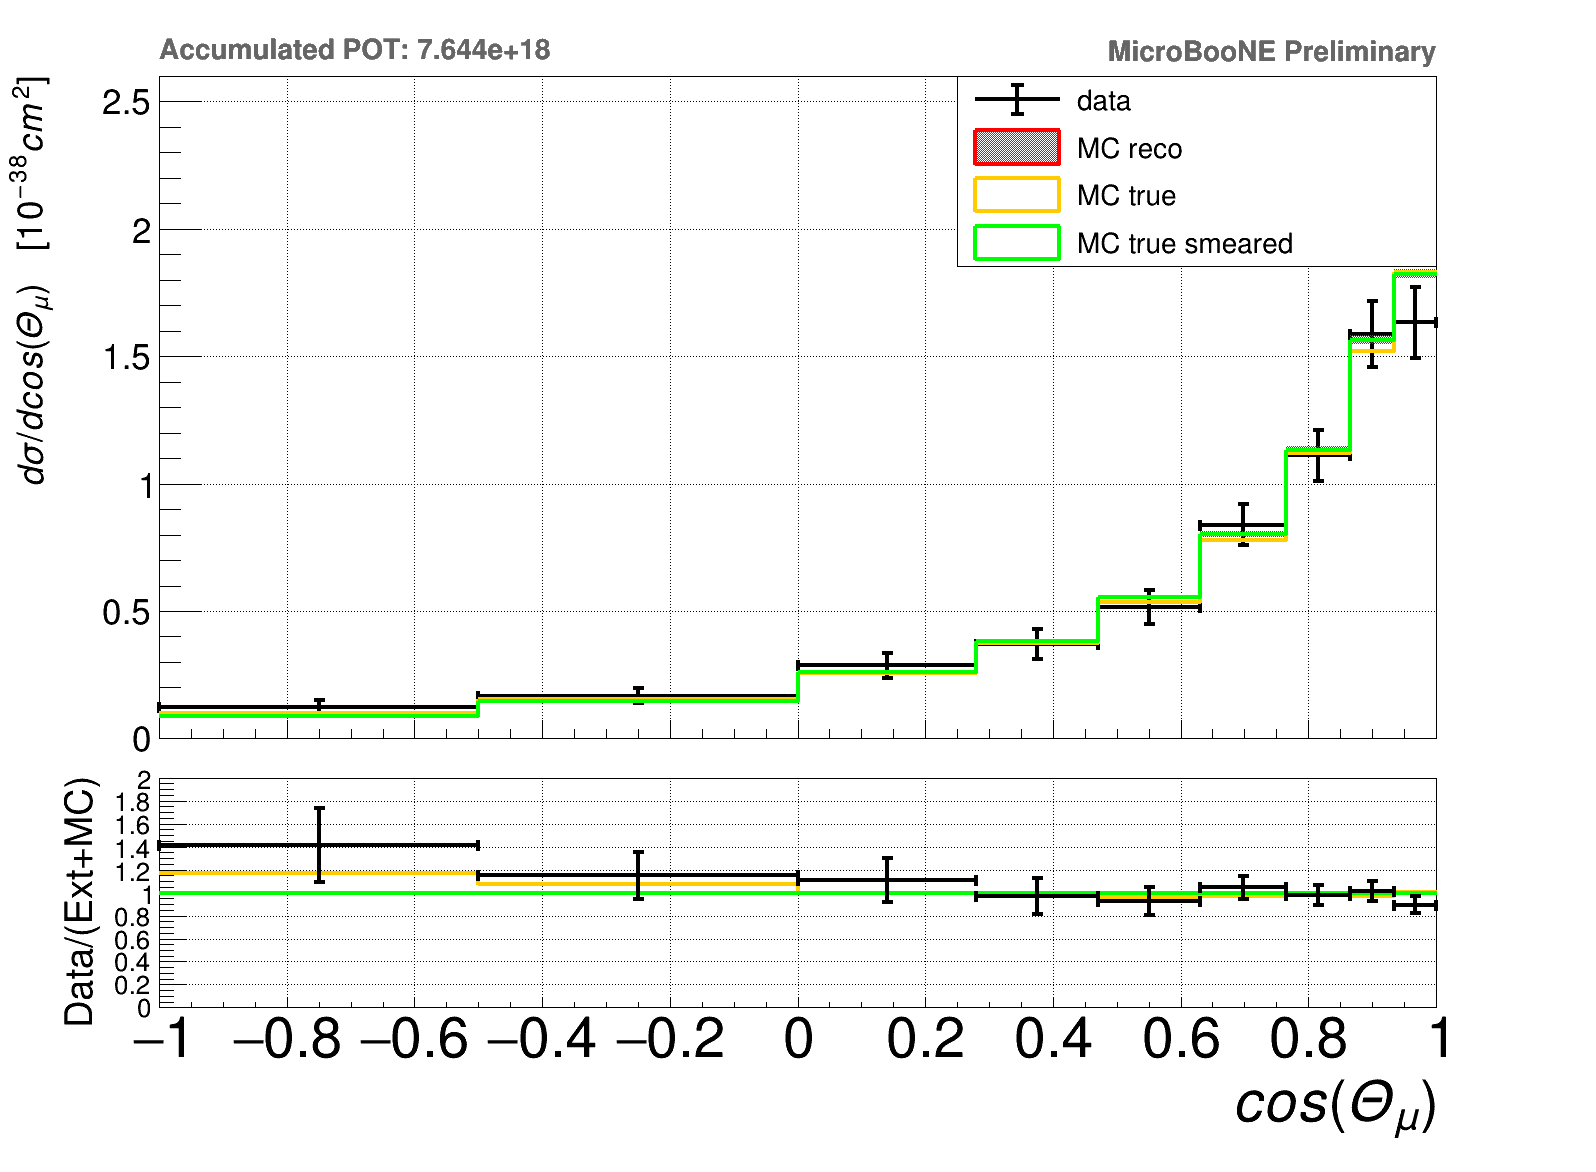

In [43]:
legend = ROOT.TLegend(0.6,0.65,0.9,0.9)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.1)
c1.SetBottomMargin(0.1)
#c1.SetFillStyle(4000);
# first pad
c1.cd()
pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
pad1.SetGrid(1)
pad1.Draw()
pad1.cd()
pad1.SetBottomMargin(0.03);
pad1.SetTopMargin(0.1)

h_overlay_sig.SetLineColor(2)
legend.AddEntry(h_data,'data',"lep");
legend.AddEntry(h_overlay_sig,'MC reco',"f");
legend.AddEntry(h_true,'MC true',"f");
legend.AddEntry(h_true_smeare,'MC true smeared',"f");

h_data.SetYTitle("d\sigma / dcos(\Theta_{\mu}) \t [10^{-38} cm^{2}]")
h_data.SetXTitle("cos(\Theta_{\mu})")
h_data.SetLineWidth(3)
h_data.SetMaximum(2.6)

h_data.GetYaxis().SetTitleSize(0.05)
h_data.GetYaxis().SetTitleOffset(0.0)
h_data.GetYaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleSize(0.05)
h_data.GetXaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleOffset(1)
h_data.SetLineColor(ROOT.kBlack)
h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.05)

h_data.GetXaxis().SetLabelOffset(999);
h_data.GetXaxis().SetTitleOffset(999);
h_data.GetXaxis().SetLabelSize(0);
h_data.GetXaxis().SetTitleSize(0);

h_data.Draw('E1')
h_overlay_sig.SetFillColor(0)
h_overlay_sig.SetLineWidth(4)
#h_overlay_sig.Draw('hist same')
h_overlay_sig.DrawCopy('Hist same')
h_overlay_sig.SetFillColor(2)
h_overlay_sig.SetFillStyle(3001)
h_overlay_sig.Draw('E2 same')
h_true.Draw('hist same')
h_true_smeare.Draw('hist same')
legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()

c1.cd()
h_data.GetXaxis().SetLabelOffset(0);
h_data.GetXaxis().SetTitleOffset(0);

pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
pad2.SetGrid(1)
pad2.SetTopMargin(0.04)
pad2.SetBottomMargin(0.4)
pad2.Draw()
pad2.cd()

h_overlay_sig_ratio = h_overlay_sig.Clone()
h_overlay_sig_ratio.Divide(h_overlay_sig)
h_overlay_true_ratio = h_true.Clone()
h_overlay_true_ratio.Divide(h_overlay_sig)
h_overlay_data_ratio = h_data.Clone()
h_overlay_data_ratio.Divide(h_overlay_sig)
h_overlay_true_smeare_ratio = h_true_smeare.Clone()
h_overlay_true_smeare_ratio.Divide(h_overlay_sig)

h_overlay_data_ratio.SetMinimum(0.0)
h_overlay_data_ratio.SetMaximum(2.0)
h_overlay_sig_ratio.SetFillColor(0)
h_overlay_data_ratio.SetYTitle('Data/(Ext+MC)')
h_overlay_data_ratio.GetYaxis().SetTitleSize(0.1)
h_overlay_data_ratio.GetYaxis().SetTitleOffset(0.3)
h_overlay_data_ratio.GetYaxis().SetLabelSize(0.07)
h_overlay_data_ratio.GetXaxis().SetTitleSize(0.15)
h_overlay_data_ratio.GetXaxis().SetLabelSize(0.15)
h_overlay_data_ratio.GetXaxis().SetTitleOffset(1)

h_overlay_data_ratio.Draw('E1')
h_overlay_true_ratio.Draw('hist same')
h_overlay_sig_ratio.Draw('same hist')
h_overlay_true_smeare_ratio.Draw('same hist')
h_overlay_data_ratio.Draw('E1 same')


c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_xsec_corr_theta_ratio.png")
c1.SaveAs(globale.outputdir_root + "h_xsec_corr_theta_ratio.root")
c1.SaveAs(globale.outputdir_pdf + "h_xsec_corr_theta_ratio.pdf")

#h_data.Write("h_xsec_data")
#h_overlay_sig.Write("h_xsec_MC")

In [44]:
# close the root file with all the histos
RootFile.Close()

In [45]:
reterastera

NameError: name 'reterastera' is not defined

In [ ]:
nenner = 'numu_true'
zahler = 'fidVol && muon && numu_signal'
cut = 'fidVol && muon'
start = time.time()
#NuCC_w.plot_eff_w(nenner,zahler,cut,'initial','initial')
end = time.time()
print(end - start)

In [ ]:
nenner = 'numu_true'
zahler = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && numu_signal'
cut = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
start = time.time()
#NuCC_w.plot_eff_w(nenner,zahler,cut,'allcut','allcut')
end = time.time()
print(end - start)

In [ ]:
nenner = 'numu_signal && fidVol && muon'
zahler = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && numu_signal'
cut = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
start = time.time()
#NuCC_w.plot_eff_w(nenner,zahler,cut,'tomcut_only','tomcut_only')
end = time.time()
print(end - start)

In [ ]:
nenner = 'numu_signal && fidVol && muon'
zahler = 'fidVol && muon && crt_tom_cut && numu_signal'
cut = 'fidVol && muon && crt_tom_cut'
start = time.time()
#NuCC_w.plot_eff_w(nenner,zahler,cut,'crtcut_only','crtcut_only')
end = time.time()
print(end - start)

In [ ]:
#NuCC_w.pdg_content33_w('fidVol && muon')

In [ ]:
#NuCC_w.pdg_content33_w('fidVol && muon && crt_tom_cut && TrackScore>0.8\
#                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1')

In [ ]:
#NuCC_w.pdg_content33_w('fidVol && muon && crt_tom_cut && TrackScore>0.8\
#                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && MCTrackPurity>0.5')

In [ ]:
#NuCC_w.pdg_content33_w('fidVol && muon && crt_tom_cut && TrackScore>0.8\
#                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && MCTrackPurity>0.5 && num_mc_muon>0')

In [ ]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

In [ ]:
value = 'TrackLength'
xbins = 30
xstart = 0
xend = 30
step = (xend-xstart)/xbins
title = 'Track length [cm]'

h_eff =  ROOT.TH1F("h_eff",title,xbins,xstart,xend)
h_pur = ROOT.TH1F("h_pur",title,xbins,xstart,xend)
h_effpur = ROOT.TH1F("h_effpur",title,xbins,xstart,xend)
for i in range(xbins): 
    cut = 'muon && fidVol && TrackPID_chimuon<30 && NuScore>0.1 && crt_tom_cut && TrackScore>0.8 && ('+value+'>('+str(xstart)+'+'+str(step)+'*'+str(i)+'))'
    #print cut
    pur = overlay_out.GetEntries(cut+' && numu_signal')*scale[overlay]*100.0/(NuCC.getTotNum_out(cut)+0.00001)
    eff = overlay_out.GetEntries(cut+' && numu_signal')*100.0/overlay_out.GetEntries("numu_true")
    h_eff.SetBinContent(i+1,eff)
    h_pur.SetBinContent(i+1,pur)
    h_effpur.SetBinContent(i+1,eff*pur/100.0)
    #print eff ,pur, eff*pur,i

legend = ROOT.TLegend(0.15,0.75,0.48,0.9);
legend.AddEntry(h_eff,"efficiency","f");
legend.AddEntry(h_pur,"purity","f");
legend.AddEntry(h_effpur,"eff * pur","f");

h_eff.SetLineColor(1)
h_eff.SetMaximum(100)
h_eff.SetMinimum(0)
h_pur.SetLineColor(2)
h_effpur.SetLineColor(3)
h_pur.SetLineWidth(3)
h_eff.SetLineWidth(3)
h_effpur.SetLineWidth(3)
h_eff.Draw()
legend.Draw()
h_pur.Draw('same')
h_effpur.Draw('same')
h_eff.Draw('same')
c1.SetLogy(0)
c1.Draw()
c1.SaveAs(outputdir_png+ value +".png");
c1.SaveAs(outputdir_root+ value+ ".root");

print 'Variation of cut on: '+value
print 'Maximum value: ', h_effpur.GetMaximum()
print 'Bin: ', h_effpur.GetMaximumBin(),' -> Value: ', xstart+(h_effpur.GetMaximumBin()-1)*step

In [ ]:
value = 'TrackPID_chimuon'
xbins = 30
xstart = 0
xend = 30
step = (xend-xstart)/xbins
title = 'Track PID chi square'

h_eff =  ROOT.TH1F("h_eff",title,xbins,xstart,xend)
h_pur = ROOT.TH1F("h_pur",title,xbins,xstart,xend)
h_effpur = ROOT.TH1F("h_effpur",title,xbins,xstart,xend)
for i in range(xbins): 
    cut = 'muon && fidVol && crt_tom_cut && TrackScore>0.8 && \
        TrackLength>20 && NuScore>0.1 && ('+value+'<('+str(xstart)+'+'+str(step)+'*'+str(i)+'))'
    #print cut
    pur = overlay_out.GetEntries(cut+' && numu_signal')*scale[overlay]*100.0/(NuCC.getTotNum_out(cut)+0.00001)
    eff = overlay_out.GetEntries(cut+' && numu_signal')*100.0/overlay_out.GetEntries("numu_true")
    h_eff.SetBinContent(i+1,eff)
    h_pur.SetBinContent(i+1,pur)
    h_effpur.SetBinContent(i+1,eff*pur/100.0)
    #print eff ,pur, eff*pur,i

legend = ROOT.TLegend(0.15,0.75,0.48,0.9);
legend.AddEntry(h_eff,"efficiency","f");
legend.AddEntry(h_pur,"purity","f");
legend.AddEntry(h_effpur,"eff * pur","f");

h_eff.SetLineColor(1)
h_eff.SetMaximum(100)
h_eff.SetMinimum(0)
h_pur.SetLineColor(2)
h_effpur.SetLineColor(3)
h_pur.SetLineWidth(3)
h_eff.SetLineWidth(3)
h_effpur.SetLineWidth(3)
h_eff.Draw()
legend.Draw()
h_pur.Draw('same')
h_effpur.Draw('same')
h_eff.Draw('same')
c1.SetLogy(0)
c1.Draw()
c1.SaveAs(outputdir_png+ value +".png");
c1.SaveAs(outputdir_root+ value+ ".root");

print 'Variation of cut on: '+value
print 'Maximum value: ', h_effpur.GetMaximum()
print 'Bin: ', h_effpur.GetMaximumBin(),' -> Value: ', xstart+(h_effpur.GetMaximumBin()-1)*step

In [ ]:
value = 'NuScore'
xbins = 20
xstart = 0
xend = 0.5
step = (xend-xstart)/xbins
title = 'Track length [cm]'

h_eff =  ROOT.TH1F("h_eff",title,xbins,xstart,xend)
h_pur = ROOT.TH1F("h_pur",title,xbins,xstart,xend)
h_effpur = ROOT.TH1F("h_effpur",title,xbins,xstart,xend)
for i in range(xbins): 
    cut = 'muon && fidVol && crt_tom_cut && TrackScore>0.8 && ('+value+'>('+str(xstart)+'+'+str(step)+'*'+str(i)+'))'
    #print cut
    pur = overlay_out.GetEntries(cut+' && numu_signal')*scale[overlay]*100.0/(NuCC.getTotNum_out(cut)+0.00001)
    eff = overlay_out.GetEntries(cut+' && numu_signal')*100.0/overlay_out.GetEntries("numu_true")
    h_eff.SetBinContent(i+1,eff)
    h_pur.SetBinContent(i+1,pur)
    h_effpur.SetBinContent(i+1,eff*pur/100.0)
    #print eff ,pur, eff*pur,i

legend = ROOT.TLegend(0.15,0.75,0.48,0.9);
legend.AddEntry(h_eff,"efficiency","f");
legend.AddEntry(h_pur,"purity","f");
legend.AddEntry(h_effpur,"eff * pur","f");

h_eff.SetLineColor(1)
h_eff.SetMaximum(100)
h_eff.SetMinimum(0)
h_pur.SetLineColor(2)
h_effpur.SetLineColor(3)
h_pur.SetLineWidth(3)
h_eff.SetLineWidth(3)
h_effpur.SetLineWidth(3)
h_eff.Draw()
legend.Draw()
h_pur.Draw('same')
h_effpur.Draw('same')
h_eff.Draw('same')
c1.SetLogy(0)
c1.Draw()
c1.SaveAs(outputdir_png+ value +".png");
c1.SaveAs(outputdir_root+ value+ ".root");

print 'Variation of cut on: '+value
print 'Maximum value: ', h_effpur.GetMaximum()
print 'Bin: ', h_effpur.GetMaximumBin(),' -> Value: ', xstart+(h_effpur.GetMaximumBin()-1)*step